In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Concatenate
from keras.layers import LSTM, Embedding, Bidirectional, GRU
from keras.layers import SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
import pickle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import collections
from sklearn.utils.class_weight import compute_class_weight
from gensim import models
import torch
from transformers import AutoModel, AutoTokenizer
from pyvi.ViTokenizer import tokenize
from tqdm import tqdm
import numpy as np

SyntaxError: invalid syntax (pywrap_tensorflow_internal.py, line 114)

In [2]:
!pip install pyvi
!pip install tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 10.7 MB/s eta 0:00:0000:0100:01


# **1.Get data and label**

In [15]:
def replace_values(value):
    if value == 0:
        return np.nan  # Thay 0 thành null (NaN)
    elif value == 1:
        return 0
    elif value == 2:
        return 1
    elif value == 3:
        return 2
    return value


data_train = pd.read_csv('/kaggle/input/sentimentabsa/data_train.csv')
data_val = pd.read_csv('/kaggle/input/sentimentabsa/data_val.csv')
data_test = pd.read_csv('/kaggle/input/sentimentabsa/data_test.csv')

# Áp dụng hàm thay thế cho các cột A, B, C, D
columns_to_replace = ['Quality', 'Smell', 'Shipping', 'Packing', 'Price', 'Other', 'General']
data_train[columns_to_replace] = data_train[columns_to_replace].applymap(replace_values)
data_test[columns_to_replace] = data_test[columns_to_replace].applymap(replace_values)
data_val[columns_to_replace] = data_val[columns_to_replace].applymap(replace_values)


data_train.drop('Unnamed: 0', axis = 1, inplace = True)
data_val.drop('Unnamed: 0', axis = 1, inplace = True)
data_test.drop('Unnamed: 0', axis = 1, inplace = True)
data_test.rename(columns={'Tokenized': 'processed_content'}, inplace=True)
data_train.rename(columns={'Tokenized': 'processed_content'}, inplace=True)
data_val.rename(columns={'Tokenized': 'processed_content'}, inplace=True)
data_test.rename(columns={'Quality': 'quality'}, inplace=True)
data_train.rename(columns={'Quality': 'quality'}, inplace=True)
data_val.rename(columns={'Quality': 'quality'}, inplace=True)
data_train.rename(columns={'Smell': 'smell'}, inplace=True)
data_test.rename(columns={'Smell': 'smell'}, inplace=True)
data_val.rename(columns={'Smell': 'smell'}, inplace=True)
data_val.rename(columns={'Shipping': 'shipping'}, inplace=True)
data_train.rename(columns={'Shipping': 'shipping'}, inplace=True)
data_test.rename(columns={'Shipping': 'shipping'}, inplace=True)
data_test.rename(columns={'Packing': 'packing'}, inplace=True)
data_train.rename(columns={'Packing': 'packing'}, inplace=True)
data_val.rename(columns={'Packing': 'packing'}, inplace=True)
data_train.rename(columns={'Price': 'price'}, inplace=True)
data_val.rename(columns={'Price': 'price'}, inplace=True)
data_test.rename(columns={'Price': 'price'}, inplace=True)
data_val.rename(columns={'Other': 'others'}, inplace=True)
data_test.rename(columns={'Other': 'others'}, inplace=True)
data_train.rename(columns={'Other': 'others'}, inplace=True)

<ipython-input-15-1b4dc075d9a1>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_train[columns_to_replace] = data_train[columns_to_replace].applymap(replace_values)
<ipython-input-15-1b4dc075d9a1>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_test[columns_to_replace] = data_test[columns_to_replace].applymap(replace_values)
<ipython-input-15-1b4dc075d9a1>:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_val[columns_to_replace] = data_val[columns_to_replace].applymap(replace_values)


In [16]:
data_train

,Content,General,others,packing,price,quality,shipping,smell,processed_content
0,mềm nhẹ nhàng,NaN,NaN,NaN,NaN,2.0,NaN,NaN,mềm nhẹ_nhàng
1,vẫn cảm thấy hơi khô da,NaN,NaN,NaN,NaN,0.0,NaN,NaN,vẫn cảm_thấy hơi khô da
2,rẻ nên mua nha mọi người,NaN,NaN,NaN,2.0,NaN,NaN,NaN,rẻ nên mua nha mọi người
3,shop rất nhiệt tình sản phẩm đáng mua,2.0,NaN,NaN,NaN,NaN,NaN,NaN,shop rất nhiệt_tình sản_phẩm đáng mua
4,còn về mặt sản phẩm thì chỉ không ưng ý cái ch...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,còn về mặt sản_phẩm thì chỉ không ưng_ý cái ch...
...,...,...,...,...,...,...,...,...,...
10193,mua lần rồi phân chính hãng,2.0,NaN,NaN,NaN,NaN,NaN,NaN,mua lần rồi phân chính hãng
10194,sài lắm nha không bị kích hay gì đâu mình lần ...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,sài lắm nha không bị kích hay gì đâu mình lần ...
10195,shipper giao thân thiện,NaN,NaN,NaN,NaN,NaN,2.0,NaN,shipper giao thân_thiện
10196,sẽ quay ủng shop tiếp okela,2.0,NaN,NaN,NaN,NaN,NaN,NaN,sẽ quay ủng shop tiếp okela


In [17]:
def get_aspect_label(df):
    df_aspect_label = pd.DataFrame(index=df.index, columns=['is_quality','is_smell', 'is_shipping', 'is_packing', 'is_price', 'is_others'])
    replace_dict = {np.nan: 0, 1: 1, 0: 1, 2: 1}
    df_aspect_label['is_quality'] = df['quality'].replace(replace_dict)
    df_aspect_label['is_smell'] = df['smell'].replace(replace_dict)
    df_aspect_label['is_shipping'] = df['shipping'].replace(replace_dict)
    df_aspect_label['is_packing'] = df['packing'].replace(replace_dict)
    df_aspect_label['is_price'] = df['price'].replace(replace_dict)
    df_aspect_label['is_others'] = df['others'].replace(replace_dict)
    df_aspect_label['is_general'] = df['General'].replace(replace_dict)
    return df_aspect_label

aspect_label_train = get_aspect_label(data_train).astype(int)
aspect_label_val = get_aspect_label(data_val).astype(int)
aspect_label_test = get_aspect_label(data_test).astype(int)

In [18]:
def get_content(df_input):
  list_aspect = list(df_input.columns[1:-1])
  content = {}
  for aspect in list_aspect:
    df_input[~df_input[f'{aspect}'].isna()]
    content[aspect] = df_input[~df_input[f'{aspect}'].isna()].processed_content.values
  return content

def get_dict_content(df_input):
  list_aspect = list(df_input.columns[1:-1])
  dict_temp = {}
  for aspect in list_aspect:
    dict_temp[aspect]= df_input[~df_input[f'{aspect}'].isna()]
  return dict_temp

def get_setiment_label(df_input):
  df = df_input.copy()
  # The error occurs because the labels in the columns might be [1, 2, 3]
  # to_categorical needs labels to be in the range [0, num_classes - 1] 
  # In your case, you've set num_classes = 3
  # Therefore, the labels should be [0, 1, 2]
  # We need to subtract 1 from each label to make them fall in this range.
  _quality = tf.keras.utils.to_categorical(df['quality'].quality - 1, num_classes = 3)
  _smell = tf.keras.utils.to_categorical(df['smell'].smell - 1, num_classes = 3)
  _shipping = tf.keras.utils.to_categorical(df['shipping'].shipping - 1, num_classes = 3)
  _packing = tf.keras.utils.to_categorical(df['packing'].packing - 1, num_classes = 3)
  _price = tf.keras.utils.to_categorical(df['price'].price - 1, num_classes = 3)
  _others = tf.keras.utils.to_categorical(df['others'].others - 1, num_classes = 3)
  _general = tf.keras.utils.to_categorical(df['General'].General - 1, num_classes = 3)

  dict_temp = {'quality': _quality,
          'smell': _smell,
          'shipping': _shipping,
          'packing': _packing,
          'price': _price,
          'others': _others,
          'General': _general}
  return dict_temp

def get_content_and_sentiment_label(data):
  df = data.copy()
  content = get_content(df)
  dict_ = get_dict_content(df)
  sentiment_label = get_setiment_label(dict_)
  del dict_
  return content, sentiment_label
     

In [19]:
content_train, sentiment_label_train = get_content_and_sentiment_label(data_train)
content_val, sentiment_label_val = get_content_and_sentiment_label(data_val)
content_test, sentiment_label_test = get_content_and_sentiment_label(data_test)

# Embbeding

In [20]:
import torch
from transformers import AutoModel, AutoTokenizer
from pyvi.ViTokenizer import tokenize
from tqdm import tqdm
import numpy as np

df = {
    'train': data_train,
    'val': data_val,
    'test': data_test
}

PhobertTokenizer = AutoTokenizer.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")
model = AutoModel.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")

def process_batch(model, tokenizer, sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output
    return outputs.cpu().numpy()
batch_size = 200
embeddings = {}

for state in tqdm(['train']):
    sentences = df[state].processed_content.values
    state_embeddings = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch_sentences = sentences[i:i+batch_size]
        batch_sentences = [tokenize(sentence) for sentence in batch_sentences]
        batch_embeddings = process_batch(model, PhobertTokenizer, batch_sentences)
        state_embeddings.append(batch_embeddings)
    embeddings[state] = np.concatenate(state_embeddings, axis=0)

np.save('/kaggle/working/embeddings_train.npy', embeddings['train'])

tokenizer_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

100%|██████████| 1/1 [07:05<00:00, 425.52s/it]


In [21]:
for state in tqdm(['val']):
    sentences = df[state].processed_content.values
    state_embeddings = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch_sentences = sentences[i:i+batch_size]
        batch_sentences = [tokenize(sentence) for sentence in batch_sentences]
        batch_embeddings = process_batch(model, PhobertTokenizer, batch_sentences)
        state_embeddings.append(batch_embeddings)
    embeddings[state] = np.concatenate(state_embeddings, axis=0)
np.save('/kaggle/working/embeddings_val.npy', embeddings['val'])

100%|██████████| 1/1 [01:22<00:00, 82.75s/it]


In [22]:
df = {
    'train': data_train,
    'val': data_val,
    'test': data_test
}

PhobertTokenizer = AutoTokenizer.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")
model = AutoModel.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")

def process_batch(model, tokenizer, sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output
    return outputs.cpu().numpy()
batch_size = 200
embeddings = {}
for state in tqdm(['test']):
    sentences = df[state].processed_content.values
    state_embeddings = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        batch_sentences = sentences[i:i+batch_size]
        batch_sentences = [tokenize(sentence) for sentence in batch_sentences]
        batch_embeddings = process_batch(model, PhobertTokenizer, batch_sentences)
        state_embeddings.append(batch_embeddings)
    embeddings[state] = np.concatenate(state_embeddings, axis=0)
np.save('/kaggle/working/embeddings_test.npy', embeddings['test'])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 1/1 [01:35<00:00, 95.53s/it]


In [23]:
embeddings = {}
for state in ['train','val','test']:
  embeddings[state] = np.load(f'/kaggle/working/embeddings_{state}.npy')


# **2.Model building**

# BILSTM

### Stage 1: Aspect detection

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def bilstm_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)
    input_layer = Input(shape=(1, embedding_dim))

    lstm_layer = Bidirectional(LSTM(units=200, activation='tanh'))(input_layer)
    aspect_dense2 = Dense(128, activation='relu')(lstm_layer)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)

    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    # Change the output layer to have 7 units to match the target shape
    aspect_dense5 = Dense(7, activation='sigmoid')(aspect_dense4)  
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)
    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model

embedding_dim = 768
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

callback = EarlyStopping(monitor='val_loss', patience=5)
model_1_1 = bilstm_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)

Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2736 - loss: 0.6451 - val_accuracy: 0.2909 - val_loss: 0.3955
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4237 - loss: 0.3495 - val_accuracy: 0.6720 - val_loss: 0.2345
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6736 - loss: 0.2328 - val_accuracy: 0.7617 - val_loss: 0.1829
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7461 - loss: 0.1870 - val_accuracy: 0.7736 - val_loss: 0.1636
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7650 - loss: 0.1690 - val_accuracy: 0.7864 - val_loss: 0.1536
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7747 - loss: 0.1569 - val_accuracy: 0.7941 - val_loss: 0.1481
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7866 - loss: 0.1481 - val_accuracy: 0.7946 - val_loss: 0.1438
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7942 - loss: 0.1419 - val_accuracy: 0.8001 - 

In [25]:
def expand_dims(data):
    return tf.expand_dims(data, axis=1)

train_data_expanded = expand_dims(embeddings['train'])
pred_train = model_1_1.predict(train_data_expanded)

val_data_expanded = expand_dims(embeddings['val'])
pred_val = model_1_1.predict(val_data_expanded)

test_data_expanded = expand_dims(embeddings['test'])
pred_test = model_1_1.predict(test_data_expanded)

df_train_pred = pd.DataFrame(np.round(pred_train, 0), columns=aspect_label_train.columns)
df_val_pred = pd.DataFrame(np.round(pred_val, 0), columns=aspect_label_val.columns)
df_test_pred = pd.DataFrame(np.round(pred_test, 0), columns=aspect_label_test.columns)

df_train_true_ = aspect_label_train
df_val_true_ = aspect_label_val
df_test_true_ = aspect_label_test

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [26]:
def get_pd_report(label_aspect_train, df_test_true_, df_test_pred):

  aspect_result_bilstm_report = {}
  for col in label_aspect_train.columns:
    aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
    aspect_result_bilstm_report[col] = pd.DataFrame(aspect_result_bilstm).T
    aspect_result_bilstm_report[col]['aspect'] = col

  output_aspect_report = pd.DataFrame()
  for indx, val in aspect_result_bilstm_report.items():
    output_aspect_report = pd.concat([output_aspect_report, aspect_result_bilstm_report[indx]])

  return output_aspect_report

In [27]:
aspect_result = {}
for col in aspect_label_train.columns:
  print(col)
  aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
  print(aspect_result_bilstm)

  aspect_result[col] = pd.DataFrame(aspect_result_bilstm).T
  aspect_result[col]['aspect'] = col

output_aspect_report = pd.DataFrame()
for indx, val in aspect_result.items():
  output_aspect_report = pd.concat([output_aspect_report, aspect_result[indx]])

is_quality
{'0': {'precision': 0.9206939281288724, 'recall': 0.9399114484503479, 'f1-score': 0.9302034428794993, 'support': 1581}, '1': {'precision': 0.8336252189141856, 'recall': 0.7880794701986755, 'f1-score': 0.8102127659574467, 'support': 604}, 'accuracy': 0.8979405034324943, 'macro avg': {'precision': 0.877159573521529, 'recall': 0.8639954593245117, 'f1-score': 0.8702081044184731, 'support': 2185}, 'weighted avg': {'precision': 0.8966255069088858, 'recall': 0.8979405034324943, 'f1-score': 0.8970343953458975, 'support': 2185}}
is_smell
{'0': {'precision': 0.9970873786407767, 'recall': 0.9946731234866828, 'f1-score': 0.9958787878787879, 'support': 2065}, '1': {'precision': 0.912, 'recall': 0.95, 'f1-score': 0.9306122448979591, 'support': 120}, 'accuracy': 0.9922196796338673, 'macro avg': {'precision': 0.9545436893203884, 'recall': 0.9723365617433414, 'f1-score': 0.9632455163883735, 'support': 2185}, 'weighted avg': {'precision': 0.9924143875941436, 'recall': 0.9922196796338673, 'f1-

#### Result Stage 1

In [28]:
for col in aspect_label_train.columns:
  print(f'----{col}----')
  aspect_result = classification_report(df_test_true_[col], df_test_pred[col])
  print(aspect_result)

----is_quality----
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1581
           1       0.83      0.79      0.81       604

    accuracy                           0.90      2185
   macro avg       0.88      0.86      0.87      2185
weighted avg       0.90      0.90      0.90      2185

----is_smell----
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2065
           1       0.91      0.95      0.93       120

    accuracy                           0.99      2185
   macro avg       0.95      0.97      0.96      2185
weighted avg       0.99      0.99      0.99      2185

----is_shipping----
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1954
           1       0.89      0.87      0.88       231

    accuracy                           0.98      2185
   macro avg       0.94      0.93      0.94      2185
weighted avg      

In [29]:
output_aspect_report.to_csv('/kaggle/working/Aspect_detection_BiLSTM.csv')

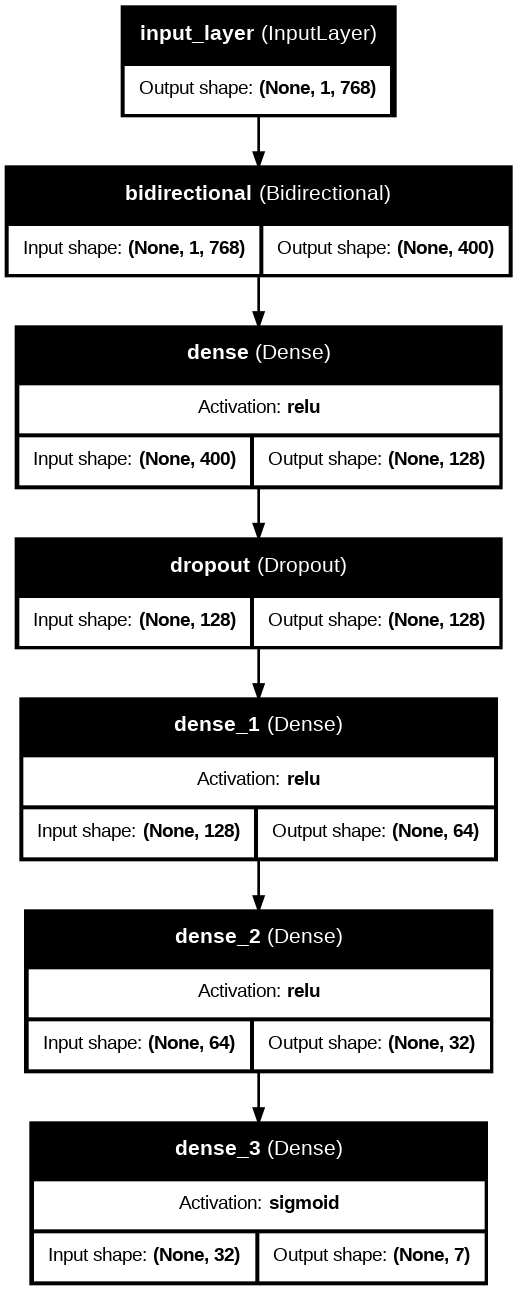

In [30]:
tf.keras.utils.plot_model(
    model_1_1, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [31]:
# plot

In [32]:
list_aspect = []
for col in aspect_label_train.columns.values:
  # if col!='is_others':
  list_aspect.append(col.split('_')[1])
list_aspect

['quality', 'smell', 'shipping', 'packing', 'price', 'others', 'general']

### Stage 2: Setiment Polarity


In [33]:
data_train['embeddings'] =  np.array(map(list, embeddings['train']))
data_val['embeddings'] =  np.array(map(list, embeddings['val']))
data_test['embeddings'] =  np.array(map(list, embeddings['test']))

# data_train['embeddings'] = data_train['embeddings'].apply(np.array)
# data_val['embeddings'] = data_val['embeddings'].apply(np.array)
# data_test['embeddings'] = data_test['embeddings'].apply(np.array)

In [34]:
def get_embeddings(df_input):
  list_aspect = list(df_input.columns[1:-1])
  embed = {}
  for aspect in list_aspect:
    df_input[~df_input[f'{aspect}'].isna()]
    embed[aspect] = df_input[~df_input[f'{aspect}'].isna()].embeddings.values
  return embed

def get_dict_content(df_input):
  list_aspect = list(df_input.columns[1:-1])
  dict_temp = {}
  for aspect in list_aspect:
    dict_temp[aspect]= df_input[~df_input[f'{aspect}'].isna()]
  return dict_temp

def get_setiment_label(df_input):
  df = df_input.copy()
  # The error occurs because the labels in the columns might be [1, 2, 3]
  # to_categorical needs labels to be in the range [0, num_classes - 1] 
  # In your case, you've set num_classes = 3
  # Therefore, the labels should be [0, 1, 2]
  # We need to subtract 1 from each label to make them fall in this range.
  _quality = tf.keras.utils.to_categorical(df['quality'].quality - 1, num_classes = 3)
  _smell = tf.keras.utils.to_categorical(df['smell'].smell - 1, num_classes = 3)
  _shipping = tf.keras.utils.to_categorical(df['shipping'].shipping - 1, num_classes = 3)
  _packing = tf.keras.utils.to_categorical(df['packing'].packing - 1, num_classes = 3)
  _price = tf.keras.utils.to_categorical(df['price'].price - 1, num_classes = 3)
  _others = tf.keras.utils.to_categorical(df['others'].others - 1, num_classes = 3)
  _general = tf.keras.utils.to_categorical(df['General'].General - 1, num_classes = 3)

  dict_temp = {'quality': _quality,
          'smell': _smell,
          'shipping': _shipping,
          'packing': _packing,
          'price': _price,
          'others': _others,
          'General': _general}
  return dict_temp

def get_content_and_sentiment_label(data):
  df = data.copy()
  embed = get_embeddings(df)
  dict_ = get_dict_content(df)
  sentiment_label = get_setiment_label(dict_)
  del dict_
  return embed, sentiment_label

In [35]:
embeddings_train, sentiment_label_train = get_content_and_sentiment_label(data_train)
embeddings_val, sentiment_label_val = get_content_and_sentiment_label(data_val)
embeddings_test, sentiment_label_test = get_content_and_sentiment_label(data_test)

In [36]:
def bilstm_polarity(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):

    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)

    input_layer = Input(shape=(1, embedding_dim))
    lstm_layer = Bidirectional(LSTM(units=200, activation='tanh'))(input_layer)

    aspect_dense2 = Dense(128, activation='relu')(lstm_layer)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)
    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    aspect_dense5 = Dense(16, activation='relu')(aspect_dense4)
    aspect_dense6 = Dense(3, activation='sigmoid')(aspect_dense5)

    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense6)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)

    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model

In [37]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# Assuming bilstm_aspect function is defined elsewhere and properly imported
# Define callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model_1 = {}
for aspect in tqdm(list_aspect):
    # Convert aspect to the expected key in embeddings_train, sentiment_label_train, etc.
    aspect_key = "General" if aspect == "general" else aspect  
    
    print(f'\n----{aspect_key}----')

    # Train the model for the current aspect
    sentiment_model_1[aspect] = bilstm_polarity(
        embedding_dim=768,
        padded_aspect_train=np.stack(embeddings_train[aspect_key]), # Use aspect_key
        padded_aspect_val=np.stack(embeddings_val[aspect_key]),    # Use aspect_key
        label_aspect_train=sentiment_label_train[aspect_key],    # Use aspect_key
        label_aspect_val=sentiment_label_val[aspect_key],      # Use aspect_key
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )

    # Save the trained model for the current aspect (if needed)
    # sentiment_model[aspect].save(f'{path}/BiLSTM/stl_BiLSTM_polarity_{aspect}')

  0%|          | 0/7 [00:00<?, ?it/s]


----quality----
Epoch 1/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8977 - loss: 0.6582 - val_accuracy: 0.9299 - val_loss: 0.5454
Epoch 2/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9130 - loss: 0.5086 - val_accuracy: 0.9299 - val_loss: 0.3539
Epoch 3/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8975 - loss: 0.3562 - val_accuracy: 0.9299 - val_loss: 0.2436
Epoch 4/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9073 - loss: 0.2634 - val_accuracy: 0.9299 - val_loss: 0.1976
Epoch 5/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9097 - loss: 0.2255 - val_accuracy: 0.9299 - val_loss: 0.1778
Epoch 6/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9118 - loss: 0.1981 - val_accuracy: 0.9299 - val_loss: 0.1611
Epoch 7/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9012 - loss: 0.1920 - val_accuracy: 0.9333 - val_loss: 0.1476
Epoch 8/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9035 - loss: 0.1778 - val_a

 14%|█▍        | 1/7 [00:06<00:40,  6.76s/it]


----smell----
Epoch 1/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.2018 - loss: 0.6888 - val_accuracy: 0.7033 - val_loss: 0.6775
Epoch 2/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6496 - loss: 0.6759 - val_accuracy: 0.7363 - val_loss: 0.6658
Epoch 3/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6808 - loss: 0.6652 - val_accuracy: 0.7363 - val_loss: 0.6544


 29%|██▊       | 2/7 [00:10<00:24,  4.85s/it]


----shipping----
Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8783 - loss: 0.6728 - val_accuracy: 0.8638 - val_loss: 0.6386
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8710 - loss: 0.6241 - val_accuracy: 0.8638 - val_loss: 0.5717
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8767 - loss: 0.5505 - val_accuracy: 0.8638 - val_loss: 0.4792


 43%|████▎     | 3/7 [00:13<00:16,  4.07s/it]


----packing----
Epoch 1/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4077 - loss: 0.6912 - val_accuracy: 0.8458 - val_loss: 0.6800
Epoch 2/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8548 - loss: 0.6767 - val_accuracy: 0.8458 - val_loss: 0.6622
Epoch 3/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8138 - loss: 0.6586 - val_accuracy: 0.8458 - val_loss: 0.6359


 57%|█████▋    | 4/7 [00:16<00:11,  3.69s/it]


----price----
Epoch 1/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9311 - loss: 0.6821 - val_accuracy: 0.9251 - val_loss: 0.6657
Epoch 2/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9454 - loss: 0.6585 - val_accuracy: 0.9251 - val_loss: 0.6352
Epoch 3/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9505 - loss: 0.6246 - val_accuracy: 0.9251 - val_loss: 0.5948


 71%|███████▏  | 5/7 [00:19<00:06,  3.44s/it]


----others----
Epoch 1/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.2508 - loss: 0.6999 - val_accuracy: 0.2500 - val_loss: 0.6955
Epoch 2/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3756 - loss: 0.6954 - val_accuracy: 0.3214 - val_loss: 0.6922
Epoch 3/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4728 - loss: 0.6922 - val_accuracy: 0.5357 - val_loss: 0.6895


 86%|████████▌ | 6/7 [00:22<00:03,  3.26s/it]


----General----
Epoch 1/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7181 - loss: 0.6818 - val_accuracy: 0.8473 - val_loss: 0.6324
Epoch 2/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8609 - loss: 0.6041 - val_accuracy: 0.8473 - val_loss: 0.4986
Epoch 3/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8597 - loss: 0.4490 - val_accuracy: 0.8473 - val_loss: 0.3296


100%|██████████| 7/7 [00:26<00:00,  3.72s/it]


In [38]:
df_sentiment_train_pred = {}
df_sentiment_train_true_ = {}

df_sentiment_val_true_ = {}
df_sentiment_val_pred = {}

df_sentiment_test_true_ = {}
df_sentiment_test_pred = {}

# Loop over each aspect to make predictions and store them
for aspect in list_aspect:
    # Convert aspect to the expected key in embeddings_train, sentiment_label_train, etc.
    aspect_key = "General" if aspect == "general" else aspect  # This line ensures correct key usage
    
    # Reshape embeddings to match the model's expected input shape
    embeddings_train_reshaped = np.stack(embeddings_train[aspect_key]).reshape(-1, 1, 768)  # Use aspect_key here
    embeddings_val_reshaped = np.stack(embeddings_val[aspect_key]).reshape(-1, 1, 768)    # Use aspect_key here
    embeddings_test_reshaped = np.stack(embeddings_test[aspect_key]).reshape(-1, 1, 768)   # Use aspect_key here

    # Make predictions for training, validation, and test datasets
    pred_sentiment_train = sentiment_model_1[aspect].predict(embeddings_train_reshaped)
    pred_sentiment_val = sentiment_model_1[aspect].predict(embeddings_val_reshaped)
    pred_sentiment_test = sentiment_model_1[aspect].predict(embeddings_test_reshaped)

    # Store predicted labels by taking the argmax (to get the class with highest probability)
    df_sentiment_train_pred[aspect] = np.argmax(pred_sentiment_train, axis=1)
    df_sentiment_val_pred[aspect] = np.argmax(pred_sentiment_val, axis=1)
    df_sentiment_test_pred[aspect] = np.argmax(pred_sentiment_test, axis=1)

    # Store true labels by taking the argmax (assuming one-hot encoded labels)
    df_sentiment_train_true_[aspect] = np.argmax(sentiment_label_train[aspect_key], axis=1)  # Use aspect_key here
    df_sentiment_val_true_[aspect] = np.argmax(sentiment_label_val[aspect_key], axis=1)      # Use aspect_key here
    df_sentiment_test_true_[aspect] = np.argmax(sentiment_label_test[aspect_key], axis=1)  

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [39]:
sentiment_result = {}
# for aspect in lst_aspect:
for aspect in list_aspect:
    sentiment_result[aspect] = pd.DataFrame(classification_report(df_sentiment_test_true_[aspect].tolist(), df_sentiment_test_pred[aspect].tolist(), output_dict=True)).T
    sentiment_result[aspect]['aspect'] = aspect

output_sentiment_report = pd.DataFrame()
for indx, val in sentiment_result.items():
  output_sentiment_report = pd.concat([output_sentiment_report, sentiment_result[indx]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

#### Result Stage 2

In [40]:
for aspect in list_aspect:
  print(f'\n----{aspect}----')
  print(output_sentiment_report[output_sentiment_report.aspect == aspect])
  print('\n')


----quality----
              precision    recall  f1-score     support   aspect
0              0.555556  0.500000  0.526316   20.000000  quality
1              0.970909  0.958707  0.964770  557.000000  quality
2              0.444444  0.592593  0.507937   27.000000  quality
accuracy       0.927152  0.927152  0.927152    0.927152  quality
macro avg      0.656970  0.683767  0.666341  604.000000  quality
weighted avg   0.933622  0.927152  0.929830  604.000000  quality



----smell----
              precision    recall  f1-score     support aspect
0              0.000000  0.000000  0.000000    6.000000  smell
1              0.733333  1.000000  0.846154   88.000000  smell
2              0.000000  0.000000  0.000000   26.000000  smell
accuracy       0.733333  0.733333  0.733333    0.733333  smell
macro avg      0.244444  0.333333  0.282051  120.000000  smell
weighted avg   0.537778  0.733333  0.620513  120.000000  smell



----shipping----
              precision    recall  f1-score     su

In [41]:
output_sentiment_report.to_csv('/kaggle/working/sentiment_BiLSTM.csv')

# BiLSTM + Conv1D



### Stage 1: Aspect detection

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, Bidirectional, LSTM, Dense, Dropout,
    BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def bilstm_aspect(embedding_dim, sequence_length, train_data, val_data, train_labels, val_labels, epochs=70, batch_size=128, callbacks=None, verbose=1):
    # Input layer
    input_layer = Input(shape=(sequence_length, embedding_dim))
    
    # BiLSTM layers
    lstm_out = Bidirectional(LSTM(200, return_sequences=True, activation='tanh'))(input_layer)
    lstm_out = Bidirectional(LSTM(100, return_sequences=True, activation='sigmoid'))(lstm_out)
    
    # Convolutional layer
    conv_out = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(lstm_out)
    
    # Pooling layers
    avg_pool = GlobalAveragePooling1D()(conv_out)
    max_pool = GlobalMaxPooling1D()(conv_out)
    concatenated = Concatenate(axis=-1)([avg_pool, max_pool])
    
    # Dense layers
    dense_out = Dropout(0.3)(BatchNormalization()(Dense(128, activation='relu')(concatenated)))
    dense_out = Dropout(0.3)(BatchNormalization()(Dense(64, activation='relu')(dense_out)))
    dense_out = Dense(32, activation='relu')(dense_out)
    
    # Output layer
    output_layer = Dense(7, activation='sigmoid')(dense_out)

    
    # Compile model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Callbacks
    default_callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]
    if callbacks:
        default_callbacks.extend(callbacks)
    
    # Train model
    history = model.fit(
        x=train_data, y=train_labels,
        validation_data=(val_data, val_labels),
        batch_size=batch_size, epochs=epochs,
        callbacks=default_callbacks, verbose=verbose
    )
    
    return model, history


# Prepare data
embedding_dim = 768
train_data = embeddings['train'].reshape((-1, embeddings['train'].shape[1] // embedding_dim, embedding_dim))
val_data = embeddings['val'].reshape((-1, embeddings['val'].shape[1] // embedding_dim, embedding_dim))
train_labels = aspect_label_train.to_numpy()
val_labels = aspect_label_val.to_numpy()
sequence_length = train_data.shape[1]

# Train model
model_2, _ = bilstm_aspect(
    embedding_dim, sequence_length, train_data, val_data, train_labels, val_labels,
    epochs=200, batch_size=128, callbacks=None, verbose=1
)


Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.2775 - loss: 0.7406 - val_accuracy: 0.1080 - val_loss: 0.6864 - learning_rate: 1.0000e-04
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5563 - loss: 0.5288 - val_accuracy: 0.3618 - val_loss: 0.6701 - learning_rate: 1.0000e-04
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6387 - loss: 0.4302 - val_accuracy: 0.3998 - val_loss: 0.6310 - learning_rate: 1.0000e-04
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7024 - loss: 0.3558 - val_accuracy: 0.6400 - val_loss: 0.5622 - learning_rate: 1.0000e-04
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7409 - loss: 0.3037 - val_accuracy: 0.7205 - val_loss: 0.4654 - learning_rate: 1.0000e-04
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7652 - loss: 0.2641 - val_accuracy: 0.7548 - val_loss: 0.3745 - learning_rate: 1.0000e-04
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 

In [43]:
def expand_dims(data):
    return tf.expand_dims(data, axis=1)

train_data_expanded = expand_dims(embeddings['train'])
pred_train = model_2.predict(train_data_expanded)

val_data_expanded = expand_dims(embeddings['val'])
pred_val = model_2.predict(val_data_expanded)

test_data_expanded = expand_dims(embeddings['test'])
pred_test = model_2.predict(test_data_expanded)

df_train_pred = pd.DataFrame(np.round(pred_train, 0), columns=aspect_label_train.columns)
df_val_pred = pd.DataFrame(np.round(pred_val, 0), columns=aspect_label_val.columns)
df_test_pred = pd.DataFrame(np.round(pred_test, 0), columns=aspect_label_test.columns)

df_train_true_ = aspect_label_train
df_val_true_ = aspect_label_val
df_test_true_ = aspect_label_test

319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [44]:
def get_pd_report(label_aspect_train, df_test_true_, df_test_pred):

  aspect_result_bilstm_report = {}
  for col in label_aspect_train.columns:
    aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
    aspect_result_bilstm_report[col] = pd.DataFrame(aspect_result_bilstm).T
    aspect_result_bilstm_report[col]['aspect'] = col

  output_aspect_report = pd.DataFrame()
  for indx, val in aspect_result_bilstm_report.items():
    output_aspect_report = pd.concat([output_aspect_report, aspect_result_bilstm_report[indx]])

  return output_aspect_report

In [45]:
aspect_result = {}
for col in aspect_label_train.columns:
  print(col)
  aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
  print(aspect_result_bilstm)

  aspect_result[col] = pd.DataFrame(aspect_result_bilstm).T
  aspect_result[col]['aspect'] = col

output_aspect_report = pd.DataFrame()
for indx, val in aspect_result.items():
  output_aspect_report = pd.concat([output_aspect_report, aspect_result[indx]])

is_quality
{'0': {'precision': 0.9228855721393034, 'recall': 0.9386464263124604, 'f1-score': 0.9306992787707745, 'support': 1581}, '1': {'precision': 0.8318890814558059, 'recall': 0.7947019867549668, 'f1-score': 0.8128704487722269, 'support': 604}, 'accuracy': 0.8988558352402746, 'macro avg': {'precision': 0.8773873267975547, 'recall': 0.8666742065337136, 'f1-score': 0.8717848637715007, 'support': 2185}, 'weighted avg': {'precision': 0.8977313934789682, 'recall': 0.8988558352402746, 'f1-score': 0.898127831027469, 'support': 2185}}
is_smell
{'0': {'precision': 0.9975716367168529, 'recall': 0.9946731234866828, 'f1-score': 0.9961202715809894, 'support': 2065}, '1': {'precision': 0.9126984126984127, 'recall': 0.9583333333333334, 'f1-score': 0.9349593495934959, 'support': 120}, 'accuracy': 0.9926773455377574, 'macro avg': {'precision': 0.9551350247076328, 'recall': 0.9765032284100081, 'f1-score': 0.9655398105872426, 'support': 2185}, 'weighted avg': {'precision': 0.9929104070224763, 'recall

#### Result Stage 1

In [46]:
for col in aspect_label_train.columns:
  print(f'----{col}----')
  aspect_result = classification_report(df_test_true_[col], df_test_pred[col])
  print(aspect_result)

----is_quality----
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1581
           1       0.83      0.79      0.81       604

    accuracy                           0.90      2185
   macro avg       0.88      0.87      0.87      2185
weighted avg       0.90      0.90      0.90      2185

----is_smell----
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2065
           1       0.91      0.96      0.93       120

    accuracy                           0.99      2185
   macro avg       0.96      0.98      0.97      2185
weighted avg       0.99      0.99      0.99      2185

----is_shipping----
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1954
           1       0.91      0.87      0.89       231

    accuracy                           0.98      2185
   macro avg       0.95      0.93      0.94      2185
weighted avg      

In [47]:
output_aspect_report.to_csv('/kaggle/working/Aspect_detection_BiLSTM_Conv.csv')

### Stage 2: Sentiment Polarity

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
def bilstm_conv_sentiment(embedding_dim, sequence_length, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    input_layer = Input(shape=(sequence_length, embedding_dim))


    lstm_layer = Bidirectional(LSTM(units=200, return_sequences=True, activation='tanh'))(input_layer)
    lstm_layer = Bidirectional(LSTM(units=100, return_sequences=True, activation='sigmoid'))(lstm_layer)


    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(lstm_layer)

    avg_pool = GlobalAveragePooling1D()(conv_layer)
    max_pool = GlobalMaxPooling1D()(conv_layer)

    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    dense1 = Dense(128, activation='relu')(concat)
    batch_norm1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.3)(batch_norm1)

    dense2 = Dense(64, activation='relu')(dropout1)
    batch_norm2 = BatchNormalization()(dense2)
    dropout2 = Dropout(0.3)(batch_norm2)

    dense3 = Dense(32, activation='relu')(dropout2)
    output_layer = Dense(3, activation='sigmoid')(dense3)


    aspect_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    callback_list = [early_stopping, reduce_lr]
    if callbacks:
        callback_list.extend(callbacks)


    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callback_list,
                               verbose=verbose)
    return aspect_model, history
embedding_dim = 768
padded_aspect_train = embeddings['train'].reshape((-1, embeddings['train'].shape[1] // embedding_dim, embedding_dim))
padded_aspect_val = embeddings['val'].reshape((-1, embeddings['val'].shape[1] // embedding_dim, embedding_dim))
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

In [49]:
list_aspect = data_train.columns[1:-2]
list_aspect

Index(['General', 'others', 'packing', 'price', 'quality', 'shipping',
       'smell'],
      dtype='object')

In [50]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# Assuming bilstm_aspect function is defined elsewhere and properly imported
# Define callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model_2 = {}

# Loop over each aspect to train the TCN model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')

    # Ensure data is stacked and reshaped correctly
    # padded_aspect_train = np.array(embeddings_train[aspect])
    # padded_aspect_val = np.array(embeddings_val[aspect])

    padded_aspect_train = np.stack(embeddings_train[aspect]).reshape((-1, np.stack(embeddings_train[aspect]).shape[1] // embedding_dim, embedding_dim))
    padded_aspect_val = np.stack(embeddings_val[aspect]).reshape((-1,np.stack(embeddings_val[aspect]).shape[1] // embedding_dim, embedding_dim))

    # Determine sequence length and embedding dimension
    sequence_length = padded_aspect_train.shape[1]
    embedding_dim = 768

    # Train the model for the current aspect
    sentiment_model_2[aspect] = bilstm_conv_sentiment(
        embedding_dim=embedding_dim,
        sequence_length=sequence_length,
        padded_aspect_train=padded_aspect_train,
        padded_aspect_val=padded_aspect_val,
        label_aspect_train=np.array(sentiment_label_train[aspect]),
        label_aspect_val=np.array(sentiment_label_val[aspect]),
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )
    # Save the trained model for the current aspect (if needed)
    # sentiment_model[aspect].save(f'{path}/BiLSTM/stl_BiLSTM_polarity_{aspect}')


  0%|          | 0/7 [00:00<?, ?it/s]


----General----
Epoch 1/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4852 - loss: 0.7279 - val_accuracy: 0.8473 - val_loss: 0.6300 - learning_rate: 1.0000e-04
Epoch 2/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7014 - loss: 0.5668 - val_accuracy: 0.8473 - val_loss: 0.6342 - learning_rate: 1.0000e-04
Epoch 3/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7830 - loss: 0.4838 - val_accuracy: 0.8473 - val_loss: 0.6385 - learning_rate: 1.0000e-04
Epoch 4/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8311 - loss: 0.4168 - val_accuracy: 0.8473 - val_loss: 0.6460 - learning_rate: 1.0000e-04


 14%|█▍        | 1/7 [00:07<00:47,  7.96s/it]


----others----
Epoch 1/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 653ms/step - accuracy: 0.2765 - loss: 0.9275 - val_accuracy: 0.4643 - val_loss: 0.6754 - learning_rate: 1.0000e-04
Epoch 2/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2560 - loss: 0.9098 - val_accuracy: 0.4643 - val_loss: 0.6740 - learning_rate: 1.0000e-04
Epoch 3/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2977 - loss: 0.8875 - val_accuracy: 0.4643 - val_loss: 0.6732 - learning_rate: 1.0000e-04


 29%|██▊       | 2/7 [00:13<00:34,  6.82s/it]


----packing----
Epoch 1/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.5715 - loss: 0.6178 - val_accuracy: 0.1417 - val_loss: 0.7076 - learning_rate: 1.0000e-04
Epoch 2/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7715 - loss: 0.4877 - val_accuracy: 0.1417 - val_loss: 0.6987 - learning_rate: 1.0000e-04
Epoch 3/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8274 - loss: 0.4280 - val_accuracy: 0.1417 - val_loss: 0.6916 - learning_rate: 1.0000e-04


 43%|████▎     | 3/7 [00:21<00:28,  7.03s/it]


----price----
Epoch 1/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.4363 - loss: 0.7196 - val_accuracy: 0.0160 - val_loss: 0.6744 - learning_rate: 1.0000e-04
Epoch 2/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5276 - loss: 0.6404 - val_accuracy: 0.0160 - val_loss: 0.6772 - learning_rate: 1.0000e-04
Epoch 3/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5276 - loss: 0.6203 - val_accuracy: 0.0160 - val_loss: 0.6767 - learning_rate: 1.0000e-04


 57%|█████▋    | 4/7 [00:27<00:20,  6.83s/it]


----quality----
Epoch 1/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.1760 - loss: 0.9300 - val_accuracy: 0.9299 - val_loss: 0.6630 - learning_rate: 1.0000e-04
Epoch 2/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3487 - loss: 0.7540 - val_accuracy: 0.9299 - val_loss: 0.6524 - learning_rate: 1.0000e-04
Epoch 3/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4785 - loss: 0.6502 - val_accuracy: 0.9299 - val_loss: 0.6419 - learning_rate: 1.0000e-04


 71%|███████▏  | 5/7 [00:35<00:14,  7.00s/it]


----shipping----
Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.1548 - loss: 1.0142 - val_accuracy: 0.8638 - val_loss: 0.5911 - learning_rate: 1.0000e-04
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2185 - loss: 0.8540 - val_accuracy: 0.8638 - val_loss: 0.5925 - learning_rate: 1.0000e-04
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2754 - loss: 0.7625 - val_accuracy: 0.8638 - val_loss: 0.5928 - learning_rate: 1.0000e-04
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3227 - loss: 0.7167 - val_accuracy: 0.8638 - val_loss: 0.5964 - learning_rate: 1.0000e-04


 86%|████████▌ | 6/7 [00:41<00:06,  6.92s/it]


----smell----
Epoch 1/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.4420 - loss: 0.7267 - val_accuracy: 0.2088 - val_loss: 0.7825 - learning_rate: 1.0000e-04
Epoch 2/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6001 - loss: 0.5994 - val_accuracy: 0.2088 - val_loss: 0.7808 - learning_rate: 1.0000e-04
Epoch 3/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6590 - loss: 0.5403 - val_accuracy: 0.2088 - val_loss: 0.7797 - learning_rate: 1.0000e-04


100%|██████████| 7/7 [00:48<00:00,  6.88s/it]


In [51]:
# Initialize dictionaries to store predictions and true labels
df_sentiment_train_pred = {}
df_sentiment_train_true_ = {}

df_sentiment_val_true_ = {}
df_sentiment_val_pred = {}

df_sentiment_test_true_ = {}
df_sentiment_test_pred = {}

# Loop over each aspect to make predictions and store them
for aspect in list_aspect:
    # Reshape embeddings to match the model's expected input shape
    embeddings_train_reshaped = np.stack(embeddings_train[aspect]).reshape(-1, 1, 768)
    embeddings_val_reshaped = np.stack(embeddings_val[aspect]).reshape(-1, 1, 768)
    embeddings_test_reshaped = np.stack(embeddings_test[aspect]).reshape(-1, 1, 768)

    # Make predictions for training, validation, and test datasets
    pred_sentiment_train = sentiment_model_2[aspect][0].predict(embeddings_train_reshaped)
    pred_sentiment_val = sentiment_model_2[aspect][0].predict(embeddings_val_reshaped)
    pred_sentiment_test = sentiment_model_2[aspect][0].predict(embeddings_test_reshaped)

    # Store predicted labels by taking the argmax (to get the class with highest probability)
    df_sentiment_train_pred[aspect] = np.argmax(pred_sentiment_train, axis=1)
    df_sentiment_val_pred[aspect] = np.argmax(pred_sentiment_val, axis=1)
    df_sentiment_test_pred[aspect] = np.argmax(pred_sentiment_test, axis=1)

    # Store true labels by taking the argmax (assuming one-hot encoded labels)
    df_sentiment_train_true_[aspect] = np.argmax(sentiment_label_train[aspect], axis=1)
    df_sentiment_val_true_[aspect] = np.argmax(sentiment_label_val[aspect], axis=1)
    df_sentiment_test_true_[aspect] = np.argmax(sentiment_label_test[aspect], axis=1)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [52]:
sentiment_result = {}
# for aspect in lst_aspect:
for aspect in list_aspect:
    sentiment_result[aspect] = pd.DataFrame(classification_report(df_sentiment_test_true_[aspect].tolist(), df_sentiment_test_pred[aspect].tolist(), output_dict=True)).T
    sentiment_result[aspect]['aspect'] = aspect

output_sentiment_report = pd.DataFrame()
for indx, val in sentiment_result.items():
  output_sentiment_report = pd.concat([output_sentiment_report, sentiment_result[indx]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

#### Result Stage 2

In [53]:
for aspect in list_aspect:
  print(f'\n----{aspect}----')
  print(output_sentiment_report[output_sentiment_report.aspect == aspect])
  print('\n')


----General----
              precision    recall  f1-score     support   aspect
0              0.000000  0.000000  0.000000   62.000000  General
1              0.877358  1.000000  0.934673  651.000000  General
2              0.000000  0.000000  0.000000   29.000000  General
accuracy       0.877358  0.877358  0.877358    0.877358  General
macro avg      0.292453  0.333333  0.311558  742.000000  General
weighted avg   0.769758  0.877358  0.820044  742.000000  General



----others----
              precision    recall  f1-score    support  aspect
0              0.000000  0.000000  0.000000  21.000000  others
1              0.382353  1.000000  0.553191  13.000000  others
accuracy       0.382353  0.382353  0.382353   0.382353  others
macro avg      0.191176  0.500000  0.276596  34.000000  others
weighted avg   0.146194  0.382353  0.211514  34.000000  others



----packing----
              precision    recall  f1-score     support   aspect
0              0.000000  0.000000  0.000000    3

In [54]:
output_sentiment_report.to_csv('/kaggle/working/sentiment_BiLSTM_Conv.csv')

# GRU

### Stage 1: Aspect Detection

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def biGRU_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    # Đảm bảo đúng định dạng dữ liệu
    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)

    # Định nghĩa mô hình
    input_layer = Input(shape=(1, embedding_dim))
    gru_layer = Bidirectional(GRU(units=200, activation='tanh'))(input_layer)
    aspect_dense2 = Dense(128, activation='relu')(gru_layer)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)
    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)

    # Sửa số lượng đầu ra để khớp với số nhãn
    aspect_dense5 = Dense(7, activation='sigmoid')(aspect_dense4)

    # Biên dịch mô hình
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Gọi lại (callbacks)
    callback = EarlyStopping(monitor='val_loss', patience=3)
    history = aspect_model.fit(
        x=padded_aspect_train,
        y=label_aspect_train,
        validation_data=(padded_aspect_val, label_aspect_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks if callbacks else [callback],
        verbose=verbose
    )

    return aspect_model

# Dữ liệu đầu vào
embedding_dim = 768
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

# Sử dụng hàm
callback = EarlyStopping(monitor='val_loss', patience=5)
model_3 = biGRU_aspect(
    embedding_dim,
    padded_aspect_train,
    padded_aspect_val,
    label_aspect_train,
    label_aspect_val,
    epochs=200,
    batch_size=128,
    callbacks=[callback],
    verbose=1
)


Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1387 - loss: 0.6053 - val_accuracy: 0.5041 - val_loss: 0.3294
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5236 - loss: 0.3075 - val_accuracy: 0.7077 - val_loss: 0.2143
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7001 - loss: 0.2119 - val_accuracy: 0.7653 - val_loss: 0.1752
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7510 - loss: 0.1784 - val_accuracy: 0.7768 - val_loss: 0.1596
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7748 - loss: 0.1586 - val_accuracy: 0.7850 - val_loss: 0.1530
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7846 - loss: 0.1521 - val_accuracy: 0.7964 - val_loss: 0.1471
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7905 - loss: 0.1448 - val_accuracy: 0.7987 - val_loss: 0.1453
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7966 - loss: 0.1397 - val_accuracy: 0.8024 - 

In [56]:
def expand_dims(data):
    return tf.expand_dims(data, axis=1)

train_data_expanded = expand_dims(embeddings['train'])
pred_train = model_3.predict(train_data_expanded)

val_data_expanded = expand_dims(embeddings['val'])
pred_val = model_3.predict(val_data_expanded)

test_data_expanded = expand_dims(embeddings['test'])
pred_test = model_3.predict(test_data_expanded)

df_train_pred = pd.DataFrame(np.round(pred_train, 0), columns=aspect_label_train.columns)
df_val_pred = pd.DataFrame(np.round(pred_val, 0), columns=aspect_label_val.columns)
df_test_pred = pd.DataFrame(np.round(pred_test, 0), columns=aspect_label_test.columns)

df_train_true_ = aspect_label_train
df_val_true_ = aspect_label_val
df_test_true_ = aspect_label_test

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [57]:
def get_pd_report(label_aspect_train, df_test_true_, df_test_pred):

  aspect_result_bilstm_report = {}
  for col in label_aspect_train.columns:
    aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
    aspect_result_bilstm_report[col] = pd.DataFrame(aspect_result_bilstm).T
    aspect_result_bilstm_report[col]['aspect'] = col

  output_aspect_report = pd.DataFrame()
  for indx, val in aspect_result_bilstm_report.items():
    output_aspect_report = pd.concat([output_aspect_report, aspect_result_bilstm_report[indx]])

  return output_aspect_report

#### Result stage 1

In [58]:
for col in aspect_label_train.columns:
  print(f'----{col}----')
  aspect_result = classification_report(df_test_true_[col], df_test_pred[col])
  print(aspect_result)

----is_quality----
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1581
           1       0.85      0.77      0.81       604

    accuracy                           0.90      2185
   macro avg       0.88      0.86      0.87      2185
weighted avg       0.90      0.90      0.90      2185

----is_smell----
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2065
           1       0.90      0.97      0.93       120

    accuracy                           0.99      2185
   macro avg       0.95      0.98      0.96      2185
weighted avg       0.99      0.99      0.99      2185

----is_shipping----
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1954
           1       0.90      0.87      0.88       231

    accuracy                           0.98      2185
   macro avg       0.94      0.93      0.93      2185
weighted avg      

In [59]:
output_aspect_report.to_csv('/kaggle/working/Aspect_detection_GRU.csv')

### Stage 2: Sentiment Polarity

In [60]:
def biGRU_polarity(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):

    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)

    input_layer = Input(shape=(1, embedding_dim))
    lstm_layer = Bidirectional(GRU(units=200, activation='tanh'))(input_layer)

    aspect_dense2 = Dense(128, activation='relu')(lstm_layer)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)
    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    aspect_dense5 = Dense(16, activation='relu')(aspect_dense4)
    aspect_dense6 = Dense(3, activation='sigmoid')(aspect_dense5)

    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense6)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)

    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model


In [61]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# Assuming bilstm_aspect function is defined elsewhere and properly imported
# Define callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model_3 = {}

# Loop over each aspect to train the BiLSTM model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')

    # Train the model for the current aspect
    sentiment_model_3[aspect] = biGRU_polarity(
        embedding_dim=768,
        padded_aspect_train=np.stack(embeddings_train[aspect]),
        padded_aspect_val=np.stack(embeddings_val[aspect]),
        label_aspect_train=sentiment_label_train[aspect],
        label_aspect_val=sentiment_label_val[aspect],
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )

    # Save the trained model for the current aspect (if needed)
    # sentiment_model[aspect].save(f'{path}/BiLSTM/stl_BiLSTM_polarity_{aspect}')


  0%|          | 0/7 [00:00<?, ?it/s]


----General----
Epoch 1/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6515 - loss: 0.6592 - val_accuracy: 0.8473 - val_loss: 0.4985
Epoch 2/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8545 - loss: 0.4373 - val_accuracy: 0.8473 - val_loss: 0.3137
Epoch 3/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8590 - loss: 0.2851 - val_accuracy: 0.8473 - val_loss: 0.2746
Epoch 4/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8665 - loss: 0.2421 - val_accuracy: 0.8473 - val_loss: 0.2450
Epoch 5/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8702 - loss: 0.2153 - val_accuracy: 0.8706 - val_loss: 0.2244
Epoch 6/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8700 - loss: 0.2067 - val_accuracy: 0.8745 - val_loss: 0.2188
Epoch 7/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8866 - loss: 0.1862 - val_accuracy: 0.8655 - val_loss: 0.2132
Epoch 8/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8873 - loss: 0.1757 - val_ac

 14%|█▍        | 1/7 [00:06<00:41,  6.85s/it]


----others----
Epoch 1/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.4162 - loss: 0.6867 - val_accuracy: 0.6786 - val_loss: 0.6743
Epoch 2/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4996 - loss: 0.6790 - val_accuracy: 0.7143 - val_loss: 0.6657
Epoch 3/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5164 - loss: 0.6695 - val_accuracy: 0.6786 - val_loss: 0.6571


 29%|██▊       | 2/7 [00:09<00:22,  4.46s/it]


----packing----
Epoch 1/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5152 - loss: 0.6865 - val_accuracy: 0.8458 - val_loss: 0.6383
Epoch 2/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8307 - loss: 0.6269 - val_accuracy: 0.8458 - val_loss: 0.5690
Epoch 3/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8133 - loss: 0.5609 - val_accuracy: 0.8458 - val_loss: 0.4754


 43%|████▎     | 3/7 [00:12<00:15,  3.81s/it]


----price----
Epoch 1/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.0125 - loss: 0.7289 - val_accuracy: 0.0160 - val_loss: 0.6999
Epoch 2/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0139 - loss: 0.7005 - val_accuracy: 0.0160 - val_loss: 0.6943
Epoch 3/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0143 - loss: 0.6948 - val_accuracy: 0.0160 - val_loss: 0.6915


 57%|█████▋    | 4/7 [00:15<00:10,  3.49s/it]


----quality----
Epoch 1/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3581 - loss: 0.6682 - val_accuracy: 0.9299 - val_loss: 0.5503
Epoch 2/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8975 - loss: 0.5118 - val_accuracy: 0.9299 - val_loss: 0.3202
Epoch 3/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8985 - loss: 0.3131 - val_accuracy: 0.9299 - val_loss: 0.1934
Epoch 4/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9101 - loss: 0.2151 - val_accuracy: 0.9299 - val_loss: 0.1698
Epoch 5/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9056 - loss: 0.2100 - val_accuracy: 0.9299 - val_loss: 0.1617
Epoch 6/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9029 - loss: 0.2018 - val_accuracy: 0.9299 - val_loss: 0.1543
Epoch 7/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9079 - loss: 0.1815 - val_accuracy: 0.9299 - val_loss: 0.1473
Epoch 8/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9076 - loss: 0.1760 - val_ac

 71%|███████▏  | 5/7 [00:22<00:09,  4.87s/it]


----shipping----
Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.0224 - loss: 0.7019 - val_accuracy: 0.0156 - val_loss: 0.6853
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0206 - loss: 0.6826 - val_accuracy: 0.0156 - val_loss: 0.6646
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0257 - loss: 0.6613 - val_accuracy: 0.0156 - val_loss: 0.6394


 86%|████████▌ | 6/7 [00:25<00:04,  4.24s/it]


----smell----
Epoch 1/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.2436 - loss: 0.6991 - val_accuracy: 0.2088 - val_loss: 0.6889
Epoch 2/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2395 - loss: 0.6869 - val_accuracy: 0.2088 - val_loss: 0.6803
Epoch 3/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2343 - loss: 0.6785 - val_accuracy: 0.2198 - val_loss: 0.6693


100%|██████████| 7/7 [00:28<00:00,  4.12s/it]


In [62]:
# Initialize dictionaries to store predictions and true labels
df_sentiment_train_pred = {}
df_sentiment_train_true_ = {}

df_sentiment_val_true_ = {}
df_sentiment_val_pred = {}

df_sentiment_test_true_ = {}
df_sentiment_test_pred = {}

# Loop over each aspect to make predictions and store them
for aspect in list_aspect:
    # Reshape embeddings to match the model's expected input shape
    embeddings_train_reshaped = np.stack(embeddings_train[aspect]).reshape(-1, 1, 768)
    embeddings_val_reshaped = np.stack(embeddings_val[aspect]).reshape(-1, 1, 768)
    embeddings_test_reshaped = np.stack(embeddings_test[aspect]).reshape(-1, 1, 768)

    # Make predictions for training, validation, and test datasets
    pred_sentiment_train = sentiment_model_3[aspect].predict(embeddings_train_reshaped)
    pred_sentiment_val = sentiment_model_3[aspect].predict(embeddings_val_reshaped)
    pred_sentiment_test = sentiment_model_3[aspect].predict(embeddings_test_reshaped)

    # Store predicted labels by taking the argmax (to get the class with highest probability)
    df_sentiment_train_pred[aspect] = np.argmax(pred_sentiment_train, axis=1)
    df_sentiment_val_pred[aspect] = np.argmax(pred_sentiment_val, axis=1)
    df_sentiment_test_pred[aspect] = np.argmax(pred_sentiment_test, axis=1)

    # Store true labels by taking the argmax (assuming one-hot encoded labels)
    df_sentiment_train_true_[aspect] = np.argmax(sentiment_label_train[aspect], axis=1)
    df_sentiment_val_true_[aspect] = np.argmax(sentiment_label_val[aspect], axis=1)
    df_sentiment_test_true_[aspect] = np.argmax(sentiment_label_test[aspect], axis=1)



105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [63]:
sentiment_result = {}
# for aspect in lst_aspect:
for aspect in list_aspect:
    sentiment_result[aspect] = pd.DataFrame(classification_report(df_sentiment_test_true_[aspect].tolist(), df_sentiment_test_pred[aspect].tolist(), output_dict=True)).T
    sentiment_result[aspect]['aspect'] = aspect

output_sentiment_report = pd.DataFrame()
for indx, val in sentiment_result.items():
  output_sentiment_report = pd.concat([output_sentiment_report, sentiment_result[indx]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

#### Result Stage 2

In [64]:
for aspect in list_aspect:
  print(f'\n----{aspect}----')
  print(output_sentiment_report[output_sentiment_report.aspect == aspect])
  print('\n')


----General----
              precision    recall  f1-score     support   aspect
0              0.551020  0.435484  0.486486   62.000000  General
1              0.936652  0.953917  0.945205  651.000000  General
2              0.633333  0.655172  0.644068   29.000000  General
accuracy       0.898922  0.898922  0.898922    0.898922  General
macro avg      0.707002  0.681524  0.691920  742.000000  General
weighted avg   0.892574  0.898922  0.895106  742.000000  General



----others----
              precision    recall  f1-score    support  aspect
0              0.740741  0.952381  0.833333  21.000000  others
1              0.857143  0.461538  0.600000  13.000000  others
accuracy       0.764706  0.764706  0.764706   0.764706  others
macro avg      0.798942  0.706960  0.716667  34.000000  others
weighted avg   0.785247  0.764706  0.744118  34.000000  others



----packing----
              precision    recall  f1-score     support   aspect
0              0.000000  0.000000  0.000000    3

In [65]:
output_sentiment_report.to_csv('/kaggle/working/sentiment_GRU.csv')

# GRU + Conv1D

#### Aspect Detection

In [66]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, GRU, Dense, Dropout, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def biGRU_conv_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=20, batch_size=128, verbose=1):
    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)
    
    input_layer = Input(shape=(1, embedding_dim))
    lstm_layer = Bidirectional(GRU(units=100, return_sequences=True, activation='tanh'))(input_layer)
    conv_layer = Conv1D(64, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(lstm_layer)
    avg_pool = GlobalAveragePooling1D()(conv_layer)
    max_pool = GlobalMaxPooling1D()(conv_layer)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    dense1 = Dense(64, activation='relu')(concat)
    dense2 = Dense(32, activation='relu')(dense1)
    output = Dense(7, activation='sigmoid')(dense2)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    callback = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    history = model.fit(
        x=padded_aspect_train,
        y=label_aspect_train,
        validation_data=(padded_aspect_val, label_aspect_val),
        batch_size=batch_size,
        steps_per_epoch=100,
        epochs=epochs,
        callbacks=[callback],
        verbose=verbose
    )
    return model

# Dữ liệu đầu vào
embedding_dim = 768
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

model = biGRU_conv_aspect(
    embedding_dim, 
    padded_aspect_train, 
    padded_aspect_val, 
    label_aspect_train, 
    label_aspect_val
)



Epoch 1/20
 80/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3244 - loss: 0.5361

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3320 - loss: 0.5152 - val_accuracy: 0.5650 - val_loss: 0.2990
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5819 - loss: 0.2764 - val_accuracy: 0.6967 - val_loss: 0.2244
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7105 - loss: 0.2109 - val_accuracy: 0.7507 - val_loss: 0.1821
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7580 - loss: 0.1737 - val_accuracy: 0.7790 - val_loss: 0.1633
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7861 - loss: 0.1544 - val_accuracy: 0.7864 - val_loss: 0.1544
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7940 - loss: 0.1478 - val_accuracy: 0.7909 - val_loss: 0.1485
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7946 - loss: 0.1429 - val_accuracy: 0.7987 - val_loss: 0.1446
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8056 - loss: 0.1360 - val_accuracy: 0.8001 - val_

In [67]:
model_gru_conv = model

In [68]:
def expand_dims(data):
    return tf.expand_dims(data, axis=1)

train_data_expanded = expand_dims(embeddings['train'])
pred_train = model_gru_conv.predict(train_data_expanded)

val_data_expanded = expand_dims(embeddings['val'])
pred_val = model_gru_conv.predict(val_data_expanded)

test_data_expanded = expand_dims(embeddings['test'])
pred_test = model_gru_conv.predict(test_data_expanded)

df_train_pred = pd.DataFrame(np.round(pred_train, 0), columns=aspect_label_train.columns)
df_val_pred = pd.DataFrame(np.round(pred_val, 0), columns=aspect_label_val.columns)
df_test_pred = pd.DataFrame(np.round(pred_test, 0), columns=aspect_label_test.columns)

df_train_true_ = aspect_label_train
df_val_true_ = aspect_label_val
df_test_true_ = aspect_label_test

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [69]:
def get_pd_report(label_aspect_train, df_test_true_, df_test_pred):

  aspect_result_bilstm_report = {}
  for col in label_aspect_train.columns:
    aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
    aspect_result_bilstm_report[col] = pd.DataFrame(aspect_result_bilstm).T
    aspect_result_bilstm_report[col]['aspect'] = col

  output_aspect_report = pd.DataFrame()
  for indx, val in aspect_result_bilstm_report.items():
    output_aspect_report = pd.concat([output_aspect_report, aspect_result_bilstm_report[indx]])

  return output_aspect_report

In [70]:
aspect_result = {}
for col in aspect_label_train.columns:
  print(col)
  aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
  print(aspect_result_bilstm)

  aspect_result[col] = pd.DataFrame(aspect_result_bilstm).T
  aspect_result[col]['aspect'] = col

output_aspect_report = pd.DataFrame()
for indx, val in aspect_result.items():
  output_aspect_report = pd.concat([output_aspect_report, aspect_result[indx]])

is_quality
{'0': {'precision': 0.91167574107683, 'recall': 0.9531941808981658, 'f1-score': 0.9319727891156463, 'support': 1581}, '1': {'precision': 0.8609022556390977, 'recall': 0.7582781456953642, 'f1-score': 0.8063380281690141, 'support': 604}, 'accuracy': 0.8993135011441648, 'macro avg': {'precision': 0.8862889983579638, 'recall': 0.855736163296765, 'f1-score': 0.8691554086423302, 'support': 2185}, 'weighted avg': {'precision': 0.8976404160404958, 'recall': 0.8993135011441648, 'f1-score': 0.897243546272733, 'support': 2185}}
is_smell
{'0': {'precision': 0.9970859640602234, 'recall': 0.9941888619854722, 'f1-score': 0.995635305528613, 'support': 2065}, '1': {'precision': 0.9047619047619048, 'recall': 0.95, 'f1-score': 0.9268292682926829, 'support': 120}, 'accuracy': 0.9917620137299771, 'macro avg': {'precision': 0.950923934411064, 'recall': 0.9720944309927361, 'f1-score': 0.961232286910648, 'support': 2185}, 'weighted avg': {'precision': 0.9920155351742747, 'recall': 0.991762013729977

#### Result stage 1

In [71]:
for col in aspect_label_train.columns:
  print(f'----{col}----')
  aspect_result = classification_report(df_test_true_[col], df_test_pred[col])
  print(aspect_result)
  

----is_quality----
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1581
           1       0.86      0.76      0.81       604

    accuracy                           0.90      2185
   macro avg       0.89      0.86      0.87      2185
weighted avg       0.90      0.90      0.90      2185

----is_smell----
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2065
           1       0.90      0.95      0.93       120

    accuracy                           0.99      2185
   macro avg       0.95      0.97      0.96      2185
weighted avg       0.99      0.99      0.99      2185

----is_shipping----
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1954
           1       0.92      0.84      0.88       231

    accuracy                           0.98      2185
   macro avg       0.95      0.92      0.93      2185
weighted avg      

In [72]:
output_aspect_report.to_csv('/kaggle/working/Aspect_detection_BiGRU_Conv.csv')

In [73]:
list_aspect = data_train.columns[1:-2]
list_aspect

Index(['General', 'others', 'packing', 'price', 'quality', 'shipping',
       'smell'],
      dtype='object')

#### Stage 2



In [74]:
data_train['embeddings'] =  np.array(map(list, embeddings['train']))
data_val['embeddings'] =  np.array(map(list, embeddings['val']))
data_test['embeddings'] =  np.array(map(list, embeddings['test']))

In [75]:
def get_embeddings(df_input):
  list_aspect = list(df_input.columns[1:-1])
  embed = {}
  for aspect in list_aspect:
    df_input[~df_input[f'{aspect}'].isna()]
    embed[aspect] = df_input[~df_input[f'{aspect}'].isna()].embeddings.values
  return embed

def get_dict_content(df_input):
  list_aspect = list(df_input.columns[1:-1])
  dict_temp = {}
  for aspect in list_aspect:
    dict_temp[aspect]= df_input[~df_input[f'{aspect}'].isna()]
  return dict_temp

def get_setiment_label(df_input):
  df = df_input.copy()
  _quality = tf.keras.utils.to_categorical(df['quality'].quality, num_classes = 3)
  _smell = tf.keras.utils.to_categorical(df['smell'].smell, num_classes = 3)
  _shipping = tf.keras.utils.to_categorical(df['shipping'].shipping, num_classes = 3)
  _packing = tf.keras.utils.to_categorical(df['packing'].packing, num_classes = 3)
  _price = tf.keras.utils.to_categorical(df['price'].price, num_classes = 3)
  _others = tf.keras.utils.to_categorical(df['others'].others, num_classes = 3)
  _general = tf.keras.utils.to_categorical(df['General'].General, num_classes = 3)


  dict_temp = {'quality': _quality,
          'smell': _smell,
          'shipping': _shipping,
          'packing': _packing,
          'price': _price,
          'others': _others,
          'General': _general}
  return dict_temp

def get_content_and_sentiment_label(data):
  df = data.copy()
  embed = get_embeddings(df)
  dict_ = get_dict_content(df)
  sentiment_label = get_setiment_label(dict_)
  del dict_
  return embed, sentiment_label

In [76]:
embeddings_train, sentiment_label_train = get_content_and_sentiment_label(data_train)
embeddings_val, sentiment_label_val = get_content_and_sentiment_label(data_val)
embeddings_test, sentiment_label_test = get_content_and_sentiment_label(data_test)

In [77]:
def biGRU_conv_sentiment(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)
    input_layer = Input(shape=(1, embedding_dim))

    #lstm_layer = Bidirectional(GRU(units=200, activation='tanh'))(input_layer)
    lstm_layer = Bidirectional(GRU(units=200, return_sequences=True, activation='tanh'))(input_layer)
    lstm_layer = Bidirectional(GRU(units=100, return_sequences=True, activation='sigmoid'))(lstm_layer)

    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(lstm_layer)

    avg_pool = GlobalAveragePooling1D()(conv_layer)
    max_pool = GlobalMaxPooling1D()(conv_layer)

    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    dense1 = Dense(128, activation='relu')(concat)
    aspect_dense2 = Dense(128, activation='relu')(dense1)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)

    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    aspect_dense5 = Dense(3, activation='sigmoid')(aspect_dense4)
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)
    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model

In [78]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# Assuming bilstm_aspect function is defined elsewhere and properly imported
# Define callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model_gru_conv = {}

# Loop over each aspect to train the BiGRU model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')

    # Train the model for the current aspect
    sentiment_model_gru_conv[aspect] = biGRU_conv_sentiment(
        embedding_dim=768,
        padded_aspect_train=np.stack(embeddings_train[aspect]),
        padded_aspect_val=np.stack(embeddings_val[aspect]),
        label_aspect_train=sentiment_label_train[aspect],
        label_aspect_val=sentiment_label_val[aspect],
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )


  0%|          | 0/7 [00:00<?, ?it/s]


----General----
Epoch 1/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.3968 - loss: 0.6622 - val_accuracy: 0.8473 - val_loss: 0.4789
Epoch 2/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8613 - loss: 0.4237 - val_accuracy: 0.8473 - val_loss: 0.3079
Epoch 3/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8636 - loss: 0.2866 - val_accuracy: 0.8473 - val_loss: 0.2886
Epoch 4/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8610 - loss: 0.2652 - val_accuracy: 0.8473 - val_loss: 0.2656
Epoch 5/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8687 - loss: 0.2317 - val_accuracy: 0.8473 - val_loss: 0.2384
Epoch 6/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8566 - loss: 0.2208 - val_accuracy: 0.8642 - val_loss: 0.2251
Epoch 7/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8627 - loss: 0.2096 - val_accuracy: 0.8771 - val_loss: 0.2204
Epoch 8/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8787 - loss: 0.2004 -

 14%|█▍        | 1/7 [00:13<01:21, 13.61s/it]


----others----
Epoch 1/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 564ms/step - accuracy: 0.3066 - loss: 0.7235 - val_accuracy: 0.4643 - val_loss: 0.7016
Epoch 2/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4676 - loss: 0.6996 - val_accuracy: 0.4643 - val_loss: 0.6820
Epoch 3/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4605 - loss: 0.6846 - val_accuracy: 0.4643 - val_loss: 0.6655


 29%|██▊       | 2/7 [00:20<00:48,  9.77s/it]


----packing----
Epoch 1/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.2733 - loss: 0.7063 - val_accuracy: 0.8458 - val_loss: 0.6520
Epoch 2/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8177 - loss: 0.6470 - val_accuracy: 0.8458 - val_loss: 0.6025
Epoch 3/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8132 - loss: 0.5989 - val_accuracy: 0.8458 - val_loss: 0.5448


 43%|████▎     | 3/7 [00:26<00:32,  8.12s/it]


----price----
Epoch 1/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.4026 - loss: 0.6629 - val_accuracy: 0.9251 - val_loss: 0.6010
Epoch 2/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9221 - loss: 0.5946 - val_accuracy: 0.9251 - val_loss: 0.5462
Epoch 3/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9419 - loss: 0.5374 - val_accuracy: 0.9251 - val_loss: 0.4839


 57%|█████▋    | 4/7 [00:32<00:21,  7.30s/it]


----quality----
Epoch 1/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.2491 - loss: 0.6932 - val_accuracy: 0.9299 - val_loss: 0.5108
Epoch 2/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9080 - loss: 0.4687 - val_accuracy: 0.9299 - val_loss: 0.2559
Epoch 3/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9007 - loss: 0.2640 - val_accuracy: 0.9299 - val_loss: 0.1758
Epoch 4/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9001 - loss: 0.2328 - val_accuracy: 0.9299 - val_loss: 0.1696
Epoch 5/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9033 - loss: 0.2177 - val_accuracy: 0.9299 - val_loss: 0.1623
Epoch 6/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9024 - loss: 0.2031 - val_accuracy: 0.9299 - val_loss: 0.1513
Epoch 7/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9051 - loss: 0.1834 - val_accuracy: 0.9299 - val_loss: 0.1399
Epoch 8/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9123 - loss: 0.1606 -

 71%|███████▏  | 5/7 [00:44<00:17,  8.94s/it]


----shipping----
Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.2471 - loss: 0.7107 - val_accuracy: 0.8638 - val_loss: 0.6168
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8682 - loss: 0.6101 - val_accuracy: 0.8638 - val_loss: 0.5546
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8802 - loss: 0.5371 - val_accuracy: 0.8638 - val_loss: 0.4675


 86%|████████▌ | 6/7 [00:50<00:07,  7.98s/it]


----smell----
Epoch 1/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.6879 - loss: 0.6737 - val_accuracy: 0.7363 - val_loss: 0.6387
Epoch 2/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6995 - loss: 0.6379 - val_accuracy: 0.7363 - val_loss: 0.6096
Epoch 3/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7021 - loss: 0.6140 - val_accuracy: 0.7363 - val_loss: 0.5841


100%|██████████| 7/7 [00:56<00:00,  8.12s/it]


In [79]:
# Initialize dictionaries to store predictions and true labels
df_sentiment_train_pred = {}
df_sentiment_train_true_ = {}

df_sentiment_val_true_ = {}
df_sentiment_val_pred = {}

df_sentiment_test_true_ = {}
df_sentiment_test_pred = {}

# Loop over each aspect to make predictions and store them
for aspect in list_aspect:
    # Reshape embeddings to match the model's expected input shape
    embeddings_train_reshaped = np.stack(embeddings_train[aspect]).reshape(-1, 1, 768)
    embeddings_val_reshaped = np.stack(embeddings_val[aspect]).reshape(-1, 1, 768)
    embeddings_test_reshaped = np.stack(embeddings_test[aspect]).reshape(-1, 1, 768)

    # Make predictions for training, validation, and test datasets
    pred_sentiment_train = sentiment_model_gru_conv[aspect].predict(embeddings_train_reshaped)
    pred_sentiment_val = sentiment_model_gru_conv[aspect].predict(embeddings_val_reshaped)
    pred_sentiment_test = sentiment_model_gru_conv[aspect].predict(embeddings_test_reshaped)

    # Store predicted labels by taking the argmax (to get the class with highest probability)
    df_sentiment_train_pred[aspect] = np.argmax(pred_sentiment_train, axis=1)
    df_sentiment_val_pred[aspect] = np.argmax(pred_sentiment_val, axis=1)
    df_sentiment_test_pred[aspect] = np.argmax(pred_sentiment_test, axis=1)

    # Store true labels by taking the argmax (assuming one-hot encoded labels)
    df_sentiment_train_true_[aspect] = np.argmax(sentiment_label_train[aspect], axis=1)
    df_sentiment_val_true_[aspect] = np.argmax(sentiment_label_val[aspect], axis=1)
    df_sentiment_test_true_[aspect] = np.argmax(sentiment_label_test[aspect], axis=1)



105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [80]:
sentiment_result = {}
# for aspect in lst_aspect:
for aspect in list_aspect:
    sentiment_result[aspect] = pd.DataFrame(classification_report(df_sentiment_test_true_[aspect].tolist(), df_sentiment_test_pred[aspect].tolist(), output_dict=True)).T
    sentiment_result[aspect]['aspect'] = aspect

output_sentiment_report = pd.DataFrame()
for indx, val in sentiment_result.items():
  output_sentiment_report = pd.concat([output_sentiment_report, sentiment_result[indx]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [81]:
output_sentiment_report

,precision,recall,f1-score,support,aspect
0,0.633333,0.655172,0.644068,29.000000,General
1,0.560000,0.451613,0.500000,62.000000,General
2,0.939577,0.955453,0.947449,651.000000,General
accuracy,0.901617,0.901617,0.901617,0.901617,General
macro avg,0.710970,0.687413,0.697172,742.000000,General
weighted avg,0.895891,0.901617,0.898204,742.000000,General
1,0.000000,0.000000,0.000000,21.000000,others
2,0.382353,1.000000,0.553191,13.000000,others
accuracy,0.382353,0.382353,0.382353,0.382353,others
macro avg,0.191176,0.500000,0.276596,34.000000,others


In [82]:
output_sentiment_report.to_csv('/kaggle/working/sentiment_GRU_Conv.csv')

# BiLSTM + BiGRU + Conv

#### Stage 1: Aspect Detection

In [84]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, GRU, Dense, Dropout, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def biLSTM_biGRU_conv_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)
    input_layer = Input(shape=(1, embedding_dim))

    # BiLSTM layer
    lstm_layer = Bidirectional(LSTM(units=200, return_sequences=True, activation='tanh'))(input_layer)
    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(lstm_layer)
    avg_pool1 = GlobalAveragePooling1D()(conv_layer)
    max_pool1 = GlobalMaxPooling1D()(conv_layer)

    # BiGRU layer
    gru_layer = Bidirectional(GRU(units=200, return_sequences=True, activation='tanh'))(input_layer)
    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(gru_layer)
    avg_pool2 = GlobalAveragePooling1D()(conv_layer)
    max_pool2 = GlobalMaxPooling1D()(conv_layer)

    # Concatenate layers
    concat = Concatenate(axis=-1)([avg_pool1, max_pool1, avg_pool2, max_pool2])

    # Dense layers
    dense1 = Dense(128, activation='relu')(concat)
    aspect_dense2 = Dense(128, activation='relu')(dense1)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)

    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    
    # Adjust the number of output units to match the number of labels
    aspect_dense5 = Dense(7, activation='sigmoid')(aspect_dense4)  # 7 output units for 7 classes

    # Compile the model
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Fit the model
    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)

    return aspect_model

# Define input data
embedding_dim = 768
padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

# Callback for early stopping
callback = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
model_biLSTM_biGRU_conv_aspect = biLSTM_biGRU_conv_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.0887 - loss: 0.5918 - val_accuracy: 0.6199 - val_loss: 0.3358
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5643 - loss: 0.3094 - val_accuracy: 0.7571 - val_loss: 0.1924
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7389 - loss: 0.1963 - val_accuracy: 0.7772 - val_loss: 0.1609
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7673 - loss: 0.1639 - val_accuracy: 0.7827 - val_loss: 0.1520
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7878 - loss: 0.1501 - val_accuracy: 0.7946 - val_loss: 0.1470
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7889 - loss: 0.1447 - val_accuracy: 0.8001 - val_loss: 0.1425
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8067 - loss: 0.1387 - val_accuracy: 0.7992 - val_loss: 0.1417
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8005 - loss: 0.1350 - val_accuracy: 0.

In [85]:
def expand_dims(data):
    return tf.expand_dims(data, axis=1)

train_data_expanded = expand_dims(embeddings['train'])
pred_train = model_biLSTM_biGRU_conv_aspect.predict(train_data_expanded)

val_data_expanded = expand_dims(embeddings['val'])
pred_val = model_biLSTM_biGRU_conv_aspect.predict(val_data_expanded)

test_data_expanded = expand_dims(embeddings['test'])
pred_test = model_biLSTM_biGRU_conv_aspect.predict(test_data_expanded)

df_train_pred = pd.DataFrame(np.round(pred_train, 0), columns=aspect_label_train.columns)
df_val_pred = pd.DataFrame(np.round(pred_val, 0), columns=aspect_label_val.columns)
df_test_pred = pd.DataFrame(np.round(pred_test, 0), columns=aspect_label_test.columns)

df_train_true_ = aspect_label_train
df_val_true_ = aspect_label_val
df_test_true_ = aspect_label_test

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [86]:
def get_pd_report(label_aspect_train, df_test_true_, df_test_pred):

  aspect_result_bilstm_report = {}
  for col in label_aspect_train.columns:
    aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
    aspect_result_bilstm_report[col] = pd.DataFrame(aspect_result_bilstm).T
    aspect_result_bilstm_report[col]['aspect'] = col

  output_aspect_report = pd.DataFrame()
  for indx, val in aspect_result_bilstm_report.items():
    output_aspect_report = pd.concat([output_aspect_report, aspect_result_bilstm_report[indx]])

  return output_aspect_report

In [87]:
for col in aspect_label_train.columns:
  print(f'----{col}----')
  aspect_result = classification_report(df_test_true_[col], df_test_pred[col])
  print(aspect_result)

----is_quality----
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1581
           1       0.86      0.74      0.80       604

    accuracy                           0.90      2185
   macro avg       0.89      0.85      0.86      2185
weighted avg       0.89      0.90      0.89      2185

----is_smell----
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2065
           1       0.89      0.98      0.93       120

    accuracy                           0.99      2185
   macro avg       0.94      0.99      0.96      2185
weighted avg       0.99      0.99      0.99      2185

----is_shipping----
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1954
           1       0.89      0.88      0.89       231

    accuracy                           0.98      2185
   macro avg       0.94      0.93      0.94      2185
weighted avg      

In [88]:
output_aspect_report.to_csv('/kaggle/working/Aspect_detection_LSTM_GRU_Conv.csv')

#### Stage 2

In [89]:
data_train['embeddings'] =  np.array(map(list, embeddings['train']))
data_val['embeddings'] =  np.array(map(list, embeddings['val']))
data_test['embeddings'] =  np.array(map(list, embeddings['test']))

In [95]:
def get_embeddings(df_input):
  list_aspect = list(df_input.columns[1:-1])
  embed = {}
  for aspect in list_aspect:
    df_input[~df_input[f'{aspect}'].isna()]
    embed[aspect] = df_input[~df_input[f'{aspect}'].isna()].embeddings.values
  return embed

def get_dict_content(df_input):
  list_aspect = list(df_input.columns[1:-1])
  dict_temp = {}
  for aspect in list_aspect:
    dict_temp[aspect]= df_input[~df_input[f'{aspect}'].isna()]
  return dict_temp

def get_setiment_label(df_input):
  df = df_input.copy()
  _quality = tf.keras.utils.to_categorical(df['quality'].quality, num_classes = 3)
  _smell = tf.keras.utils.to_categorical(df['smell'].smell, num_classes = 3)
  _shipping = tf.keras.utils.to_categorical(df['shipping'].shipping, num_classes = 3)
  _packing = tf.keras.utils.to_categorical(df['packing'].packing, num_classes = 3)
  _price = tf.keras.utils.to_categorical(df['price'].price, num_classes = 3)
  _others = tf.keras.utils.to_categorical(df['others'].others, num_classes = 3)
  _general = tf.keras.utils.to_categorical(df['General'].General, num_classes = 3)

  dict_temp = {'quality': _quality,
          'smell': _smell,
          'shipping': _shipping,
          'packing': _packing,
          'price': _price,
          'others': _others,
           'General': _general}
  return dict_temp

def get_content_and_sentiment_label(data):
  df = data.copy()
  embed = get_embeddings(df)
  dict_ = get_dict_content(df)
  sentiment_label = get_setiment_label(dict_)
  del dict_
  return embed, sentiment_label

In [96]:
embeddings_train, sentiment_label_train = get_content_and_sentiment_label(data_train)
embeddings_val, sentiment_label_val = get_content_and_sentiment_label(data_val)
embeddings_test, sentiment_label_test = get_content_and_sentiment_label(data_test)

In [97]:
def biLSTM_biGRU_conv_sentiment(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, callbacks=None, verbose=1):
    padded_aspect_train = tf.expand_dims(padded_aspect_train, axis=1)
    padded_aspect_val = tf.expand_dims(padded_aspect_val, axis=1)
    input_layer = Input(shape=(1, embedding_dim))

    #lstm_layer = Bidirectional(GRU(units=200, activation='tanh'))(input_layer)
    lstm_layer = Bidirectional(LSTM(units=200, return_sequences=True, activation='tanh'))(input_layer)
    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(lstm_layer)
    avg_pool1 = GlobalAveragePooling1D()(conv_layer)
    max_pool1 = GlobalMaxPooling1D()(conv_layer)

    gru_layer = Bidirectional(GRU(units=200, return_sequences=True, activation='tanh'))(input_layer)
    conv_layer = Conv1D(128, kernel_size=1, padding="valid", kernel_initializer="he_uniform")(gru_layer)
    avg_pool2 = GlobalAveragePooling1D()(conv_layer)
    max_pool2 = GlobalMaxPooling1D()(conv_layer)


    concat = Concatenate(axis=-1)([avg_pool1, max_pool1, avg_pool2, max_pool2])

    dense1 = Dense(128, activation='relu')(concat)
    aspect_dense2 = Dense(128, activation='relu')(dense1)
    aspect_dropout1 = Dropout(0.2)(aspect_dense2)

    aspect_dense3 = Dense(64, activation='relu')(aspect_dropout1)
    aspect_dense4 = Dense(32, activation='relu')(aspect_dense3)
    aspect_dense5 = Dense(3, activation='sigmoid')(aspect_dense4)
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss', patience=3)
    history = aspect_model.fit(x=padded_aspect_train,
                               y=label_aspect_train,
                               validation_data=(padded_aspect_val, label_aspect_val),
                               batch_size=batch_size,
                               epochs=epochs,
                               callbacks=callbacks if callbacks else [callback],
                               verbose=verbose)
    return aspect_model

In [98]:
list_aspect = data_train.columns[1:-2]
list_aspect


Index(['General', 'others', 'packing', 'price', 'quality', 'shipping',
       'smell'],
      dtype='object')

In [99]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# Assuming bilstm_aspect function is defined elsewhere and properly imported
# Define callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model_lstm_gru_conv = {}

# Loop over each aspect to train the BiLSTM model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')

    # Train the model for the current aspect
    sentiment_model_lstm_gru_conv[aspect] = biLSTM_biGRU_conv_sentiment(
        embedding_dim=768,
        padded_aspect_train=np.stack(embeddings_train[aspect]),
        padded_aspect_val=np.stack(embeddings_val[aspect]),
        label_aspect_train=sentiment_label_train[aspect],
        label_aspect_val=sentiment_label_val[aspect],
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )

    # Save the trained model for the current aspect (if needed)
    # sentiment_model[aspect].save(f'{path}/BiLSTM/stl_BiLSTM_polarity_{aspect}')


  0%|          | 0/7 [00:00<?, ?it/s]


----General----
Epoch 1/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8416 - loss: 0.6045 - val_accuracy: 0.8473 - val_loss: 0.3214
Epoch 2/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8541 - loss: 0.2896 - val_accuracy: 0.8473 - val_loss: 0.2719
Epoch 3/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8583 - loss: 0.2521 - val_accuracy: 0.8473 - val_loss: 0.2388
Epoch 4/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8577 - loss: 0.2196 - val_accuracy: 0.8590 - val_loss: 0.2246
Epoch 5/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8612 - loss: 0.2123 - val_accuracy: 0.8719 - val_loss: 0.2197
Epoch 6/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8710 - loss: 0.1974 - val_accuracy: 0.8668 - val_loss: 0.2137
Epoch 7/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8739 - loss: 0.1890 - val_accuracy: 0.8706 - val_loss: 0.2138
Epoch 8/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8763 - loss: 0.1789 -

 14%|█▍        | 1/7 [00:11<01:09, 11.56s/it]


----others----
Epoch 1/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 531ms/step - accuracy: 0.4411 - loss: 0.6857 - val_accuracy: 0.5357 - val_loss: 0.6769
Epoch 2/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5183 - loss: 0.6750 - val_accuracy: 0.4643 - val_loss: 0.6669
Epoch 3/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5112 - loss: 0.6662 - val_accuracy: 0.5357 - val_loss: 0.6555


 29%|██▊       | 2/7 [00:16<00:38,  7.62s/it]


----packing----
Epoch 1/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.5002 - loss: 0.6601 - val_accuracy: 0.8458 - val_loss: 0.5817
Epoch 2/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8278 - loss: 0.5624 - val_accuracy: 0.8458 - val_loss: 0.4768
Epoch 3/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8123 - loss: 0.4731 - val_accuracy: 0.8458 - val_loss: 0.3839


 43%|████▎     | 3/7 [00:21<00:26,  6.55s/it]


----price----
Epoch 1/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8339 - loss: 0.6674 - val_accuracy: 0.9251 - val_loss: 0.6029
Epoch 2/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9509 - loss: 0.5801 - val_accuracy: 0.9251 - val_loss: 0.4725
Epoch 3/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9465 - loss: 0.4450 - val_accuracy: 0.9251 - val_loss: 0.3259


 57%|█████▋    | 4/7 [00:26<00:18,  6.01s/it]


----quality----
Epoch 1/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7245 - loss: 0.6137 - val_accuracy: 0.9299 - val_loss: 0.3067
Epoch 2/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9056 - loss: 0.2770 - val_accuracy: 0.9299 - val_loss: 0.1683
Epoch 3/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9030 - loss: 0.2149 - val_accuracy: 0.9299 - val_loss: 0.1581
Epoch 4/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9040 - loss: 0.1932 - val_accuracy: 0.9316 - val_loss: 0.1438
Epoch 5/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9063 - loss: 0.1741 - val_accuracy: 0.9419 - val_loss: 0.1323
Epoch 6/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9116 - loss: 0.1630 - val_accuracy: 0.9402 - val_loss: 0.1232
Epoch 7/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9254 - loss: 0.1392 - val_accuracy: 0.9368 - val_loss: 0.1181
Epoch 8/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9327 - loss: 0.1188 -

 71%|███████▏  | 5/7 [00:36<00:14,  7.26s/it]


----shipping----
Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.7732 - loss: 0.6578 - val_accuracy: 0.8638 - val_loss: 0.5221
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8755 - loss: 0.4757 - val_accuracy: 0.8638 - val_loss: 0.3434
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8579 - loss: 0.3298 - val_accuracy: 0.8638 - val_loss: 0.2569


 86%|████████▌ | 6/7 [00:41<00:06,  6.55s/it]


----smell----
Epoch 1/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.2993 - loss: 0.6907 - val_accuracy: 0.7802 - val_loss: 0.6629
Epoch 2/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7369 - loss: 0.6585 - val_accuracy: 0.8571 - val_loss: 0.6271
Epoch 3/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7756 - loss: 0.6252 - val_accuracy: 0.8462 - val_loss: 0.5869


100%|██████████| 7/7 [00:46<00:00,  6.65s/it]


In [100]:
# Initialize dictionaries to store predictions and true labels
df_sentiment_train_pred = {}
df_sentiment_train_true_ = {}

df_sentiment_val_true_ = {}
df_sentiment_val_pred = {}

df_sentiment_test_true_ = {}
df_sentiment_test_pred = {}

# Loop over each aspect to make predictions and store them
for aspect in list_aspect:
    # Reshape embeddings to match the model's expected input shape
    embeddings_train_reshaped = np.stack(embeddings_train[aspect]).reshape(-1, 1, 768)
    embeddings_val_reshaped = np.stack(embeddings_val[aspect]).reshape(-1, 1, 768)
    embeddings_test_reshaped = np.stack(embeddings_test[aspect]).reshape(-1, 1, 768)

    # Make predictions for training, validation, and test datasets
    pred_sentiment_train = sentiment_model_lstm_gru_conv[aspect].predict(embeddings_train_reshaped)
    pred_sentiment_val = sentiment_model_lstm_gru_conv[aspect].predict(embeddings_val_reshaped)
    pred_sentiment_test = sentiment_model_lstm_gru_conv[aspect].predict(embeddings_test_reshaped)

    # Store predicted labels by taking the argmax (to get the class with highest probability)
    df_sentiment_train_pred[aspect] = np.argmax(pred_sentiment_train, axis=1)
    df_sentiment_val_pred[aspect] = np.argmax(pred_sentiment_val, axis=1)
    df_sentiment_test_pred[aspect] = np.argmax(pred_sentiment_test, axis=1)

    # Store true labels by taking the argmax (assuming one-hot encoded labels)
    df_sentiment_train_true_[aspect] = np.argmax(sentiment_label_train[aspect], axis=1)
    df_sentiment_val_true_[aspect] = np.argmax(sentiment_label_val[aspect], axis=1)
    df_sentiment_test_true_[aspect] = np.argmax(sentiment_label_test[aspect], axis=1)



105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [101]:
sentiment_result = {}
# for aspect in lst_aspect:
for aspect in list_aspect:
    sentiment_result[aspect] = pd.DataFrame(classification_report(df_sentiment_test_true_[aspect].tolist(), df_sentiment_test_pred[aspect].tolist(), output_dict=True)).T
    sentiment_result[aspect]['aspect'] = aspect

output_sentiment_report = pd.DataFrame()
for indx, val in sentiment_result.items():
  output_sentiment_report = pd.concat([output_sentiment_report, sentiment_result[indx]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [102]:
output_sentiment_report

,precision,recall,f1-score,support,aspect
0,0.628571,0.758621,0.687500,29.000000,General
1,0.530612,0.419355,0.468468,62.000000,General
2,0.942249,0.952381,0.947288,651.000000,General
accuracy,0.900270,0.900270,0.900270,0.900270,General
macro avg,0.700478,0.710119,0.701085,742.000000,General
weighted avg,0.895594,0.900270,0.897125,742.000000,General
1,0.571429,0.380952,0.457143,21.000000,others
2,0.350000,0.538462,0.424242,13.000000,others
accuracy,0.441176,0.441176,0.441176,0.441176,others
macro avg,0.460714,0.459707,0.440693,34.000000,others


In [103]:
output_sentiment_report.to_csv('/kaggle/working/sentiment_LSTM_GRU_Conv.csv')

# TCN

### Stage 1: Aspect Detection

In [105]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def tcn_aspect(embedding_dim, sequence_length, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, learning_rate=0.0001, conv_filters=64, kernel_size=3, dropout_rate=0.2, callbacks=None, verbose=1):
    input_layer = Input(shape=(sequence_length, embedding_dim))

    # TCN block
    conv_layer1 = Conv1D(filters=conv_filters, kernel_size=kernel_size, dilation_rate=1, padding='causal', activation='relu')(input_layer)
    conv_layer2 = Conv1D(filters=conv_filters, kernel_size=kernel_size, dilation_rate=2, padding='causal', activation='relu')(conv_layer1)
    conv_layer3 = Conv1D(filters=conv_filters, kernel_size=kernel_size, dilation_rate=4, padding='causal', activation='relu')(conv_layer2)

    flatten_layer = Flatten()(conv_layer3)

    # Dense and Dropout layers
    dense_layer1 = Dense(128, activation='relu')(flatten_layer)
    dropout_layer1 = Dropout(dropout_rate)(dense_layer1)

    dense_layer2 = Dense(64, activation='relu')(dropout_layer1)
    dense_layer3 = Dense(32, activation='relu')(dense_layer2)
    
    # Adjust the number of output units to match the number of labels
    output_layer = Dense(7, activation='sigmoid')(dense_layer3)  # 7 output units for 7 classes

    # Define and compile the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = model.fit(x=padded_aspect_train,
                        y=label_aspect_train,
                        validation_data=(padded_aspect_val, label_aspect_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks if callbacks else [callback],
                        verbose=verbose)
    return model

# Assuming embeddings and labels are defined as follows
embedding_dim = 768

# Ensure that the training and validation data are reshaped properly
padded_aspect_train = embeddings['train'].reshape((-1, embeddings['train'].shape[1] // embedding_dim, embedding_dim))
padded_aspect_val = embeddings['val'].reshape((-1, embeddings['val'].shape[1] // embedding_dim, embedding_dim))
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

sequence_length = padded_aspect_train.shape[1]

# Define EarlyStopping callback
callback = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
model_4 = tcn_aspect(embedding_dim, sequence_length, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.1025 - loss: 0.6604 - val_accuracy: 0.1258 - val_loss: 0.4332
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1918 - loss: 0.4001 - val_accuracy: 0.3463 - val_loss: 0.3438
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3837 - loss: 0.3432 - val_accuracy: 0.5668 - val_loss: 0.3045
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5415 - loss: 0.2994 - val_accuracy: 0.5942 - val_loss: 0.2575
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5829 - loss: 0.2591 - val_accuracy: 0.6743 - val_loss: 0.2234
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6738 - loss: 0.2198 - val_accuracy: 0.7251 - val_loss: 0.1966
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7179 - loss: 0.1946 - val_accuracy: 0.7457 - val_loss: 0.1806
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7494 - loss: 0.1778 - val_accuracy: 0.7644 - 

In [106]:
def expand_dims(data):
    return tf.expand_dims(data, axis=1)

train_data_expanded = expand_dims(embeddings['train'])
pred_train = model_4.predict(train_data_expanded)

val_data_expanded = expand_dims(embeddings['val'])
pred_val = model_4.predict(val_data_expanded)

test_data_expanded = expand_dims(embeddings['test'])
pred_test = model_4.predict(test_data_expanded)

df_train_pred = pd.DataFrame(np.round(pred_train, 0), columns=aspect_label_train.columns)
df_val_pred = pd.DataFrame(np.round(pred_val, 0), columns=aspect_label_val.columns)
df_test_pred = pd.DataFrame(np.round(pred_test, 0), columns=aspect_label_test.columns)

df_train_true_ = aspect_label_train
df_val_true_ = aspect_label_val
df_test_true_ = aspect_label_test

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [107]:
def get_pd_report(label_aspect_train, df_test_true_, df_test_pred):

  aspect_result_bilstm_report = {}
  for col in label_aspect_train.columns:
    aspect_result_bilstm = classification_report(df_test_true_[col], df_test_pred[col], output_dict=True)
    aspect_result_bilstm_report[col] = pd.DataFrame(aspect_result_bilstm).T
    aspect_result_bilstm_report[col]['aspect'] = col

  output_aspect_report = pd.DataFrame()
  for indx, val in aspect_result_bilstm_report.items():
    output_aspect_report = pd.concat([output_aspect_report, aspect_result_bilstm_report[indx]])

  return output_aspect_report

####  Result Stage 1

In [108]:
for col in aspect_label_train.columns:
  print(f'----{col}----')
  aspect_result = classification_report(df_test_true_[col], df_test_pred[col])
  print(aspect_result)

----is_quality----
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1581
           1       0.83      0.77      0.80       604

    accuracy                           0.89      2185
   macro avg       0.87      0.86      0.86      2185
weighted avg       0.89      0.89      0.89      2185

----is_smell----
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2065
           1       0.90      0.93      0.92       120

    accuracy                           0.99      2185
   macro avg       0.95      0.96      0.96      2185
weighted avg       0.99      0.99      0.99      2185

----is_shipping----
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1954
           1       0.88      0.87      0.87       231

    accuracy                           0.97      2185
   macro avg       0.93      0.93      0.93      2185
weighted avg      

In [109]:
output_aspect_report.to_csv('/kaggle/working/Aspect_detection_TCN.csv')

### Stage 2: Sentiment Polarity

In [110]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

def tcn_sentiment(embedding_dim, sequence_length, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, learning_rate=0.0001, conv_filters=64, kernel_size=3, dropout_rate=0.2, callbacks=None, verbose=1):
    input_layer = Input(shape=(sequence_length, embedding_dim))

    # TCN block
    conv_layer1 = Conv1D(filters=conv_filters, kernel_size=kernel_size, dilation_rate=1, padding='causal', activation='relu')(input_layer)
    conv_layer2 = Conv1D(filters=conv_filters, kernel_size=kernel_size, dilation_rate=2, padding='causal', activation='relu')(conv_layer1)
    conv_layer3 = Conv1D(filters=conv_filters, kernel_size=kernel_size, dilation_rate=4, padding='causal', activation='relu')(conv_layer2)

    flatten_layer = Flatten()(conv_layer3)

    # Dense and Dropout layers
    dense_layer1 = Dense(128, activation='relu')(flatten_layer)
    dropout_layer1 = Dropout(dropout_rate)(dense_layer1)

    dense_layer2 = Dense(64, activation='relu')(dropout_layer1)
    dense_layer3 = Dense(32, activation='relu')(dense_layer2)
    output_layer = Dense(3, activation='sigmoid')(dense_layer3)

    # Define and compile the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = model.fit(x=padded_aspect_train,
                        y=label_aspect_train,
                        validation_data=(padded_aspect_val, label_aspect_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks if callbacks else [callback],
                        verbose=verbose)
    return model

# Assuming embeddings_train, embeddings_val, sentiment_label_train, sentiment_label_val, and list_aspect are defined
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model_4 = {}

# Loop over each aspect to train the TCN model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')

    # Ensure data is stacked and reshaped correctly
    # padded_aspect_train = np.array(embeddings_train[aspect])
    # padded_aspect_val = np.array(embeddings_val[aspect])

    padded_aspect_train = np.stack(embeddings_train[aspect]).reshape((-1, np.stack(embeddings_train[aspect]).shape[1] // embedding_dim, embedding_dim))
    padded_aspect_val = np.stack(embeddings_val[aspect]).reshape((-1,np.stack(embeddings_val[aspect]).shape[1] // embedding_dim, embedding_dim))

    # Determine sequence length and embedding dimension
    sequence_length = padded_aspect_train.shape[1]
    embedding_dim = 768

    # Train the model for the current aspect
    sentiment_model_4[aspect] = tcn_sentiment(
        embedding_dim=embedding_dim,
        sequence_length=sequence_length,
        padded_aspect_train=padded_aspect_train,
        padded_aspect_val=padded_aspect_val,
        label_aspect_train=np.array(sentiment_label_train[aspect]),
        label_aspect_val=np.array(sentiment_label_val[aspect]),
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )


  0%|          | 0/7 [00:00<?, ?it/s]


----General----
Epoch 1/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.5984 - loss: 0.6877 - val_accuracy: 0.8473 - val_loss: 0.6616
Epoch 2/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8612 - loss: 0.6407 - val_accuracy: 0.8473 - val_loss: 0.5453
Epoch 3/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8595 - loss: 0.4933 - val_accuracy: 0.8473 - val_loss: 0.3445
Epoch 4/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8623 - loss: 0.3064 - val_accuracy: 0.8473 - val_loss: 0.2913
Epoch 5/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8650 - loss: 0.2627 - val_accuracy: 0.8473 - val_loss: 0.2759
Epoch 6/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8687 - loss: 0.2457 - val_accuracy: 0.8473 - val_loss: 0.2595
Epoch 7/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8664 - loss: 0.2305 - val_accuracy: 0.8473 - val_loss: 0.2433
Epoch 8/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8670 - loss: 0.2117 - val_

 14%|█▍        | 1/7 [00:14<01:24, 14.14s/it]


----others----
Epoch 1/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step - accuracy: 0.4367 - loss: 0.6936 - val_accuracy: 0.5357 - val_loss: 0.6917
Epoch 2/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5030 - loss: 0.6923 - val_accuracy: 0.5714 - val_loss: 0.6906
Epoch 3/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4668 - loss: 0.6913 - val_accuracy: 0.6071 - val_loss: 0.6896


 29%|██▊       | 2/7 [00:22<00:53, 10.73s/it]


----packing----
Epoch 1/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 413ms/step - accuracy: 0.5083 - loss: 0.6929 - val_accuracy: 0.8458 - val_loss: 0.6879
Epoch 2/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8048 - loss: 0.6874 - val_accuracy: 0.8458 - val_loss: 0.6801
Epoch 3/120
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8114 - loss: 0.6791 - val_accuracy: 0.8458 - val_loss: 0.6680


 43%|████▎     | 3/7 [00:29<00:35,  8.94s/it]


----price----
Epoch 1/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 564ms/step - accuracy: 0.9381 - loss: 0.6850 - val_accuracy: 0.9251 - val_loss: 0.6770
Epoch 2/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9466 - loss: 0.6726 - val_accuracy: 0.9251 - val_loss: 0.6616
Epoch 3/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9377 - loss: 0.6565 - val_accuracy: 0.9251 - val_loss: 0.6406


 57%|█████▋    | 4/7 [00:36<00:24,  8.11s/it]


----quality----
Epoch 1/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.8973 - loss: 0.6810 - val_accuracy: 0.9299 - val_loss: 0.6428
Epoch 2/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9080 - loss: 0.6217 - val_accuracy: 0.9299 - val_loss: 0.5114
Epoch 3/120
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9132 - loss: 0.4649 - val_accuracy: 0.9299 - val_loss: 0.2835


 71%|███████▏  | 5/7 [00:46<00:17,  8.91s/it]


----shipping----
Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 355ms/step - accuracy: 0.8026 - loss: 0.6886 - val_accuracy: 0.8638 - val_loss: 0.6808
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8688 - loss: 0.6759 - val_accuracy: 0.8638 - val_loss: 0.6609
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8697 - loss: 0.6529 - val_accuracy: 0.8638 - val_loss: 0.6260


 86%|████████▌ | 6/7 [00:53<00:08,  8.16s/it]


----smell----
Epoch 1/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 691ms/step - accuracy: 0.5956 - loss: 0.6929 - val_accuracy: 0.7473 - val_loss: 0.6912
Epoch 2/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7020 - loss: 0.6911 - val_accuracy: 0.7473 - val_loss: 0.6896
Epoch 3/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7052 - loss: 0.6895 - val_accuracy: 0.7363 - val_loss: 0.6877


100%|██████████| 7/7 [00:59<00:00,  8.48s/it]


In [111]:
# Initialize dictionaries to store predictions and true labels
df_sentiment_train_pred = {}
df_sentiment_train_true_ = {}

df_sentiment_val_true_ = {}
df_sentiment_val_pred = {}

df_sentiment_test_true_ = {}
df_sentiment_test_pred = {}

# Loop over each aspect to make predictions and store them
for aspect in list_aspect:
    # Reshape embeddings to match the model's expected input shape
    embeddings_train_reshaped = np.stack(embeddings_train[aspect]).reshape(-1, 1, 768)
    embeddings_val_reshaped = np.stack(embeddings_val[aspect]).reshape(-1, 1, 768)
    embeddings_test_reshaped = np.stack(embeddings_test[aspect]).reshape(-1, 1, 768)

    # Make predictions for training, validation, and test datasets
    pred_sentiment_train = sentiment_model_4[aspect].predict(embeddings_train_reshaped)
    pred_sentiment_val = sentiment_model_4[aspect].predict(embeddings_val_reshaped)
    pred_sentiment_test = sentiment_model_4[aspect].predict(embeddings_test_reshaped)

    # Store predicted labels by taking the argmax (to get the class with highest probability)
    df_sentiment_train_pred[aspect] = np.argmax(pred_sentiment_train, axis=1)
    df_sentiment_val_pred[aspect] = np.argmax(pred_sentiment_val, axis=1)
    df_sentiment_test_pred[aspect] = np.argmax(pred_sentiment_test, axis=1)

    # Store true labels by taking the argmax (assuming one-hot encoded labels)
    df_sentiment_train_true_[aspect] = np.argmax(sentiment_label_train[aspect], axis=1)
    df_sentiment_val_true_[aspect] = np.argmax(sentiment_label_val[aspect], axis=1)
    df_sentiment_test_true_[aspect] = np.argmax(sentiment_label_test[aspect], axis=1)


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [112]:
sentiment_result = {}
# for aspect in lst_aspect:
for aspect in list_aspect:
    sentiment_result[aspect] = pd.DataFrame(classification_report(df_sentiment_test_true_[aspect].tolist(), df_sentiment_test_pred[aspect].tolist(), output_dict=True)).T
    sentiment_result[aspect]['aspect'] = aspect

output_sentiment_report = pd.DataFrame()
for indx, val in sentiment_result.items():
  output_sentiment_report = pd.concat([output_sentiment_report, sentiment_result[indx]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

#### Result Stage 2

In [113]:
for aspect in list_aspect:
  print(f'\n----{aspect}----')
  print(output_sentiment_report[output_sentiment_report.aspect == aspect])
  print('\n')


----General----
              precision    recall  f1-score     support   aspect
0              0.567568  0.724138  0.636364   29.000000  General
1              0.568182  0.403226  0.471698   62.000000  General
2              0.939486  0.953917  0.946646  651.000000  General
accuracy       0.898922  0.898922  0.898922    0.898922  General
macro avg      0.691745  0.693760  0.684903  742.000000  General
weighted avg   0.893924  0.898922  0.894834  742.000000  General



----others----
              precision    recall  f1-score    support  aspect
1              0.625000  0.952381  0.754717  21.000000  others
2              0.500000  0.076923  0.133333  13.000000  others
accuracy       0.617647  0.617647  0.617647   0.617647  others
macro avg      0.562500  0.514652  0.444025  34.000000  others
weighted avg   0.577206  0.617647  0.517129  34.000000  others



----packing----
              precision    recall  f1-score     support   aspect
0              0.000000  0.000000  0.000000   35

In [115]:
output_sentiment_report.to_csv('/kaggle/working/sentiment_TCN.csv')

In [116]:
from tqdm import tqdm
import tensorflow as tf
import numpy as np

# Assuming bilstm_aspect function is defined elsewhere and properly imported
# Define callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Initialize the dictionary to hold the models for each aspect
sentiment_model = {}

# Loop over each aspect to train the BiLSTM model
for aspect in tqdm(list_aspect):
    print(f'\n----{aspect}----')
    sequence_length = padded_aspect_train.shape[1]
    # Train the model for the current aspect
    sentiment_model[aspect] = tcn_polarity(
        embedding_dim=768,
        sequence_length = sequence_length,
        padded_aspect_train=np.stack(embeddings_train[aspect]),
        padded_aspect_val=np.stack(embeddings_val[aspect]),
        label_aspect_train=sentiment_label_train[aspect],
        label_aspect_val=sentiment_label_val[aspect],
        epochs=120,
        callbacks=[callback],
        batch_size=128,
        verbose=1
    )

    # Save the trained model for the current aspect (if needed)
    # sentiment_model[aspect].save(f'{path}/BiLSTM/stl_BiLSTM_polarity_{aspect}')


  0%|          | 0/7 [00:00<?, ?it/s]


----General----


NameError: name 'tcn_polarity' is not defined

# TRANSFORMER

In [122]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def transformer_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=70, batch_size=128, learning_rate=0.0001, num_heads=8, ff_dim=128, dropout_rate=0.2, callbacks=None, verbose=1):
    input_layer = Input(shape=(None, embedding_dim))

    # Transformer block
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(input_layer, input_layer)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([input_layer, attention_output])  # Residual connection
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output_resized = Dense(embedding_dim)(ff_output)  # Resize to match attention_output shape

    ff_output_resized = Add()([attention_output, ff_output_resized])  # Residual connection
    ff_output_resized = LayerNormalization(epsilon=1e-6)(ff_output_resized)

    global_avg_pooling = GlobalAveragePooling1D()(ff_output_resized)

    # Dense and Dropout layers
    dense_layer1 = Dense(128, activation='relu')(global_avg_pooling)
    dropout_layer1 = Dropout(dropout_rate)(dense_layer1)

    dense_layer2 = Dense(64, activation='relu')(dropout_layer1)
    dense_layer3 = Dense(32, activation='relu')(dense_layer2)
    output_layer = Dense(7, activation='sigmoid')(dense_layer3)

    # Define and compile the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    callback = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = model.fit(x=padded_aspect_train,
                        y=label_aspect_train,
                        validation_data=(padded_aspect_val, label_aspect_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks if callbacks else [callback],
                        verbose=verbose)
    return model

# Assuming embeddings and labels are defined
embedding_dim = 768
# Convert the data to have shape (batch_size, sequence_length, embedding_dim)
padded_aspect_train = np.expand_dims(embeddings['train'], axis=1)  # If sequence_length = 1
padded_aspect_val = np.expand_dims(embeddings['val'], axis=1)  # If sequence_length = 1
label_aspect_train = aspect_label_train.to_numpy()
label_aspect_val = aspect_label_val.to_numpy()

# Define and train the model
model = transformer_aspect(embedding_dim, padded_aspect_train, padded_aspect_val, label_aspect_train, label_aspect_val, epochs=200, batch_size=128, callbacks=[callback], verbose=1)


Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.4794 - loss: 0.3563 - val_accuracy: 0.7855 - val_loss: 0.1653
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7695 - loss: 0.1742 - val_accuracy: 0.7992 - val_loss: 0.1476
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7877 - loss: 0.1519 - val_accuracy: 0.8074 - val_loss: 0.1381
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8105 - loss: 0.1344 - val_accuracy: 0.8092 - val_loss: 0.1349
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8158 - loss: 0.1274 - val_accuracy: 0.8060 - val_loss: 0.1341
Epoch 6/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8214 - loss: 0.1240 - val_accuracy: 0.8092 - val_loss: 0.1338
Epoch 7/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8270 - loss: 0.1192 - val_accuracy: 0.8115 - val_loss: 0.1337
Epoch 8/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8295 - loss: 0.1188 - val_accuracy: 0.8065 -

In [123]:
len(padded_aspect_train)

10198